# model.py

In [13]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from queue import PriorityQueue

class SeqEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim,
                 num_layers, rnn_type, dropout):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        RNN = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[rnn_type]
        self.rnn  = RNN(embed_dim, hidden_dim, num_layers,
                        batch_first=True,
                        dropout=dropout if num_layers>1 else 0)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        # x: [B, S]
        e, hid = self.drop(self.embed(x)), None
        out, hid = self.rnn(e)
        return out, hid

class SeqDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim,
                 num_layers, rnn_type, dropout):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        RNN = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[rnn_type]
        self.rnn  = RNN(embed_dim, hidden_dim, num_layers,
                        batch_first=True,
                        dropout=dropout if num_layers>1 else 0)
        self.out  = nn.Linear(hidden_dim, vocab_size)
        self.drop = nn.Dropout(dropout)

    def forward(self, token, hid):
        # token: [B]
        t = token.unsqueeze(1)               # [B,1]
        e = self.drop(self.embed(t))         # [B,1,E]
        o, h = self.rnn(e, hid)              # o:[B,1,H]
        return self.out(o.squeeze(1)), h     # logits, new hidden

class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx  = pad_idx
        self.device   = device

    def _align_hidden(self, enc_hidden):
        """
        Align encoder hidden (and cell for LSTM) to decoder.num_layers.
        """
        dec_layers = self.decoder.rnn.num_layers

        # LSTM: enc_hidden is (h, c)
        if isinstance(enc_hidden, tuple):
            h, c = enc_hidden
            enc_layers, B, H = h.size()
            h0 = torch.zeros(dec_layers, B, H, device=self.device)
            c0 = torch.zeros(dec_layers, B, H, device=self.device)
            n = min(enc_layers, dec_layers)
            h0[-n:] = h[-n:]
            c0[-n:] = c[-n:]
            return (h0, c0)

        # RNN/GRU: enc_hidden is tensor
        else:
            h = enc_hidden
            enc_layers, B, H = h.size()
            h0 = torch.zeros(dec_layers, B, H, device=self.device)
            n = min(enc_layers, dec_layers)
            h0[-n:] = h[-n:]
            return h0

    def forward(self, src, tgt, teacher_prob=0.5):
        """
        src: [B, S_src], tgt: [B, S_tgt]
        returns: [B, S_tgt, V]
        """
        B, T = tgt.size()
        V    = self.decoder.out.out_features
        out  = torch.zeros(B, T, V, device=self.device)

        # 1) encode
        _, enc_hid = self.encoder(src)
        # 2) align hidden to decoder layers
        dec_hid = self._align_hidden(enc_hid)
        # 3) decode step by step
        token = tgt[:,0]  # <sos>
        for t in range(1, T):
            logits, dec_hid = self.decoder(token, dec_hid)
            out[:,t] = logits
            token = tgt[:,t] if random.random() < teacher_prob else logits.argmax(1)
        return out

    def beam_search(self, src, sos_idx, eos_idx, beam_k=3, max_len=32):
        """
        Greedy beam search for a single sequence src: [S_src]
        returns: list of token indices
        """
        self.eval()
        with torch.no_grad():
            _, enc_hid = self.encoder(src.unsqueeze(0))
            dec_hid    = self._align_hidden(enc_hid)

            class Node:
                def __init__(self, hid, prev, tok, logp, length):
                    self.hid, self.prev, self.tok = hid, prev, tok
                    self.logp, self.len = logp, length
                def score(self): return self.logp / self.len

            root = Node(dec_hid, None,
                        torch.tensor([sos_idx], device=self.device),
                        0.0, 1)

            pq, completed = PriorityQueue(), []
            pq.put((-root.score(), root))

            while not pq.empty():
                _, node = pq.get()
                if node.tok.item() == eos_idx and node.prev:
                    completed.append((node.score(), node))
                    if len(completed) >= beam_k: break

                logits, new_hid = self.decoder(node.tok, node.hid)
                logps  = F.log_softmax(logits, dim=1).squeeze(0)
                topv, topi = logps.topk(beam_k)
                for i in range(beam_k):
                    tok_i    = topi[i].unsqueeze(0)
                    new_node = Node(new_hid, node, tok_i,
                                    node.logp + topv[i].item(),
                                    node.len+1)
                    pq.put((-new_node.score(), new_node))

            best = sorted(completed, key=lambda x: x[0], reverse=True)[0][1]
            seq  = []
            while best.prev:
                seq.append(best.tok.item())
                best = best.prev
            return seq[::-1]


In [4]:
import wandb
wandb.login(key="f0880f1a8675dc5a9ff218689c5340669690b6e0")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ed24s401 (ed24s401-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### train.py

In [14]:

import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

DATA_FOLDER = "/kaggle/input/translit"
LANG        = "hi"
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SWEEP_CONFIG = {
    "method": "bayes",
    "metric": {"name": "val_acc", "goal": "maximize"},
    "parameters": {
        "embed_dim":      {"values": [16, 32, 64, 256]},
        "hidden_dim":     {"values": [16, 32, 64, 256]},
        "encoder_layers": {"values": [1, 2, 3]},
        "decoder_layers": {"values": [1, 2, 3]},
        "rnn_type":       {"values": ["RNN", "GRU", "LSTM"]},
        "dropout":        {"values": [0.2, 0.3]},
        "beam_size":      {"values": [1, 3, 5]},
        "learning_rate":  {"values": [1e-2, 1e-3, 5e-4]},
        "batch_size":     {"values": [32, 64]},
        "epochs":         {"value": 10},
        "max_len":        {"value": 32},
        "language":       {"value": LANG},
    }
}


# ────────────────────────────────────────────────────────────────────────────────
# 4) HELPERS
# ────────────────────────────────────────────────────────────────────────────────

def compute_accuracy(logits, targets, pad_idx):
    preds = logits.argmax(-1)
    mask  = (targets != pad_idx)
    return ((preds == targets) & mask).sum().float() / mask.sum().float()

def collate_batch(batch, pad_src, pad_tgt):
    srcs, tgts = zip(*batch)
    srcs_p = pad_sequence(srcs, batch_first=True, padding_value=pad_src)
    tgts_p = pad_sequence(tgts, batch_first=True, padding_value=pad_tgt)
    return srcs_p, tgts_p


# ────────────────────────────────────────────────────────────────────────────────
# 5) TRAIN & VALID LOOPS
# ────────────────────────────────────────────────────────────────────────────────

def train_epoch(model, loader, optimizer, loss_fn, pad_idx):
    model.train()
    total_loss, total_acc = 0.0, 0.0
    for src, tgt in loader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        out = model(src, tgt, teacher_prob=0.5)
        B, T, V = out.shape
        loss = loss_fn(
            out[:,1:,:].reshape(-1, V),
            tgt[:,1:].reshape(-1)
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc  += compute_accuracy(out[:,1:,:], tgt[:,1:], pad_idx).item()
    return total_loss/len(loader), total_acc/len(loader)

@torch.no_grad()
def validate_epoch(model, loader, loss_fn, pad_idx):
    model.eval()
    total_loss, total_acc = 0.0, 0.0
    for src, tgt in loader:
        src, tgt = src.to(device), tgt.to(device)
        out = model(src, tgt, teacher_prob=0.0)
        B, T, V = out.shape
        total_loss += loss_fn(
            out[:,1:,:].reshape(-1, V),
            tgt[:,1:].reshape(-1)
        ).item()
        total_acc  += compute_accuracy(out[:,1:,:], tgt[:,1:], pad_idx).item()
    return total_loss/len(loader), total_acc/len(loader)


# ────────────────────────────────────────────────────────────────────────────────
# 6) CORE EXPERIMENT
# ────────────────────────────────────────────────────────────────────────────────

def run_experiment():
    wandb.init()
    cfg = wandb.config

    # build vocab from train split
    train_fp = os.path.join(DATA_FOLDER, f"{cfg.language}.translit.sampled.train.tsv")
    df = pd.read_csv(train_fp, sep="\t", names=["tgt","src","_"], usecols=[0,1]).dropna()
    src_map = create_mapping(df["src"].tolist())
    tgt_map = create_mapping(df["tgt"].tolist())

    # datasets & loaders
    ds_train = TranslitDataset(
        os.path.join(DATA_FOLDER, f"{cfg.language}.translit.sampled.train.tsv"),
        src_map, tgt_map, cfg.max_len
    )
    ds_dev  = TranslitDataset(
        os.path.join(DATA_FOLDER, f"{cfg.language}.translit.sampled.dev.tsv"),
        src_map, tgt_map, cfg.max_len
    )
    ds_test = TranslitDataset(
        os.path.join(DATA_FOLDER, f"{cfg.language}.translit.sampled.test.tsv"),
        src_map, tgt_map, cfg.max_len
    )

    pad_src = src_map["<pad>"]
    pad_tgt = tgt_map["<pad>"]
    train_loader = DataLoader(
        ds_train, batch_size=cfg.batch_size, shuffle=True,
        collate_fn=lambda b: collate_batch(b, pad_src, pad_tgt)
    )
    dev_loader  = DataLoader(
        ds_dev,  batch_size=cfg.batch_size, shuffle=False,
        collate_fn=lambda b: collate_batch(b, pad_src, pad_tgt)
    )
    test_loader = DataLoader(
        ds_test, batch_size=cfg.batch_size, shuffle=False,
        collate_fn=lambda b: collate_batch(b, pad_src, pad_tgt)
    )

    # model / optimizer / loss
    enc = SeqEncoder(
        vocab_size=len(src_map),
        embed_dim=cfg.embed_dim,
        hidden_dim=cfg.hidden_dim,
        num_layers=cfg.encoder_layers,
        rnn_type=cfg.rnn_type,
        dropout=cfg.dropout
    )
    dec = SeqDecoder(
        vocab_size=len(tgt_map),
        embed_dim=cfg.embed_dim,
        hidden_dim=cfg.hidden_dim,
        num_layers=cfg.decoder_layers,
        rnn_type=cfg.rnn_type,
        dropout=cfg.dropout
    )
    model     = Seq2SeqModel(enc, dec, pad_src, device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_src)

    # training loop
    for epoch in range(1, cfg.epochs + 1):
        tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion, pad_src)
        dv_loss, dv_acc = validate_epoch(model, dev_loader,     criterion, pad_src)
        wandb.log({
            "epoch":       epoch,
            "train_loss":  tr_loss, "train_acc":  tr_acc,
            "val_loss":    dv_loss, "val_acc":    dv_acc
        })

    # final test
    ts_loss, ts_acc = validate_epoch(model, test_loader, criterion, pad_src)
    wandb.log({"test_loss": ts_loss, "test_acc": ts_acc})

# ────────────────────────────────────────────────────────────────────────────────
# 7) LAUNCH SWEEP
# ────────────────────────────────────────────────────────────────────────────────

if __name__ == "__main__":
    sweep_id = wandb.sweep(SWEEP_CONFIG, project="dakshina_translit_assignment3")
    wandb.agent(sweep_id, function=run_experiment)

Create sweep with ID: 9pjlvkha
Sweep URL: https://wandb.ai/ed24s401-indian-institute-of-technology-madras/dakshina_translit_assignment3/sweeps/9pjlvkha


wandb: Agent Starting Run: ia9khor6 with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	decoder_layers: 2
wandb: 	dropout: 0.3
wandb: 	embed_dim: 32
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	language: hi
wandb: 	learning_rate: 0.0005
wandb: 	max_len: 32
wandb: 	rnn_type: RNN


epoch,▁▂▃▃▄▅▆▆▇█
test_acc,▁
test_loss,▁
train_acc,▁▂▃▃▄▆▆▇██
train_loss,█▇▆▅▅▃▂▂▁▁
val_acc,▁▁▂▂▄▆▇▇▇█
val_loss,███▆▅▃▃▂▂▁
epoch,10
test_acc,0.34347
test_loss,2.45404
train_acc,0.37952


wandb: Agent Starting Run: 5wrfoonl with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	decoder_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	language: hi
wandb: 	learning_rate: 0.01
wandb: 	max_len: 32
wandb: 	rnn_type: GRU


epoch,▁▂▃▃▄▅▆▆▇█
test_acc,▁
test_loss,▁
train_acc,▁▆▇▇██████
train_loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▆▇▆▆█▆▆██
val_loss,█▂▂▂▃▁▃▃▂▃
epoch,10
test_acc,0.52615
test_loss,1.59153
train_acc,0.55302


wandb: Agent Starting Run: odt75z6a with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 1
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 16
wandb: 	encoder_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_dim: 32
wandb: 	language: hi
wandb: 	learning_rate: 0.01
wandb: 	max_len: 32
wandb: 	rnn_type: RNN


epoch,▁▂▃▃▄▅▆▆▇█
test_acc,▁
test_loss,▁
train_acc,▁▅▇▆▇▇▇▇██
train_loss,█▃▂▃▂▂▂▂▁▂
val_acc,███▆▁████▇
val_loss,▂▄▂▇█▁▁▃▂▃
epoch,10
test_acc,0.20003
test_loss,3.16905
train_acc,0.21963


wandb: Agent Starting Run: 8eexzyf1 with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 3
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_dim: 32
wandb: 	language: hi
wandb: 	learning_rate: 0.01
wandb: 	max_len: 32
wandb: 	rnn_type: RNN


wandb: Ctrl + C detected. Stopping sweep.


# FINAL


In [ ]:
import wandb
wandb.login(key="f0880f1a8675dc5a9ff218689c5340669690b6e0")

In [3]:
# train_dakshina.py

import os, random
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import wandb
from queue import PriorityQueue

# ────────────────────────────────────────────────────────────────────────────────
# 1) CONFIGURE YOUR DATA LOCATION & LANGUAGE
# ────────────────────────────────────────────────────────────────────────────────

# Change these if needed:
DATA_DIR = "/kaggle/input/translit"       
LANG     = "hi"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ────────────────────────────────────────────────────────────────────────────────
# 2) CHAR VOCAB & DATASET
# ────────────────────────────────────────────────────────────────────────────────

def build_char_vocab(texts, specials=['<pad>','<sos>','<eos>']):
    """Map every character in `texts` plus specials to unique ints."""
    chars = set("".join(texts))
    m = {tok:i for i, tok in enumerate(specials)}
    for ch in sorted(chars):
        if ch not in m:
            m[ch] = len(m)
    return m

class TranslitDataset(Dataset):
    """
    Expects a TSV with columns [tgt, src, _]. Drops nulls.
    Returns (src_ids, tgt_ids) where
      src: [char...] + <eos>
      tgt: <sos> + [char...] + <eos>
    """
    def __init__(self, path, src_map, tgt_map, max_len=32):
        df = pd.read_csv(path, sep="\t",
                         names=["tgt","src","_"], usecols=[0,1])\
               .dropna().astype(str)
        self.pairs   = list(zip(df["src"], df["tgt"]))
        self.src_map = src_map
        self.tgt_map = tgt_map
        self.max_len = max_len

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, i):
        src, tgt = self.pairs[i]
        src_ids = [ self.src_map.get(c, self.src_map["<pad>"])
                   for c in src ][:self.max_len] \
                 + [self.src_map["<eos>"]]
        tgt_ids = [self.tgt_map["<sos>"]] \
                 + [ self.tgt_map.get(c, self.tgt_map["<pad>"])
                     for c in tgt ][:self.max_len] \
                 + [self.tgt_map["<eos>"]]
        return torch.tensor(src_ids), torch.tensor(tgt_ids)

def collate_batch(batch, pad_src, pad_tgt):
    srcs, tgts = zip(*batch)
    srcs_p = pad_sequence(srcs, batch_first=True, padding_value=pad_src)
    tgts_p = pad_sequence(tgts, batch_first=True, padding_value=pad_tgt)
    return srcs_p, tgts_p

# ────────────────────────────────────────────────────────────────────────────────
# 3) SEQ2SEQ MODEL + BEAM SEARCH
# ────────────────────────────────────────────────────────────────────────────────

class SeqEncoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hid_size, n_layers, cell, dropout):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_size)
        RNN = {"RNN":nn.RNN, "GRU":nn.GRU, "LSTM":nn.LSTM}[cell]
        self.rnn  = RNN(emb_size, hid_size, n_layers,
                        batch_first=True,
                        dropout=dropout if n_layers>1 else 0)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        e, h = self.drop(self.embed(x)), None
        out, h = self.rnn(e)
        return out, h

class SeqDecoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hid_size, n_layers, cell, dropout):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_size)
        RNN = {"RNN":nn.RNN, "GRU":nn.GRU, "LSTM":nn.LSTM}[cell]
        self.rnn  = RNN(emb_size, hid_size, n_layers,
                        batch_first=True,
                        dropout=dropout if n_layers>1 else 0)
        self.fc   = nn.Linear(hid_size, vocab_size)
        self.drop = nn.Dropout(dropout)
    def forward(self, token, hid):
        # token: [B]
        t = token.unsqueeze(1)           # [B,1]
        e = self.drop(self.embed(t))     # [B,1,emb]
        o, h = self.rnn(e, hid)          # [B,1,hid]
        return self.fc(o.squeeze(1)), h  # logits [B,vocab], new hidden

class Seq2Seq(nn.Module):
    def __init__(self, enc, dec, pad_idx, device):
        super().__init__()
        self.enc     = enc
        self.dec     = dec
        self.pad_idx = pad_idx
        self.device  = device

    def _align_hidden(self, hidden):
        """Copy/truncate encoder hidden to match decoder layers."""
        dec_layers = self.dec.rnn.num_layers
        if isinstance(hidden, tuple):  # LSTM
            h, c = hidden
            enc_layers, B, H = h.size()
            h0 = torch.zeros(dec_layers,B,H,device=self.device)
            c0 = torch.zeros(dec_layers,B,H,device=self.device)
            n = min(enc_layers, dec_layers)
            h0[-n:], c0[-n:] = h[-n:], c[-n:]
            return (h0, c0)
        else:  # GRU/RNN
            h = hidden
            enc_layers, B, H = h.size()
            h0 = torch.zeros(dec_layers,B,H,device=self.device)
            n = min(enc_layers, dec_layers)
            h0[-n:] = h[-n:]
            return h0

    def forward(self, src, tgt, teacher_prob=0.5):
        B, T = tgt.size()
        V    = self.dec.fc.out_features
        logits = torch.zeros(B,T,V,device=self.device)

        _, enc_hid = self.enc(src)
        dec_hid    = self._align_hidden(enc_hid)
        token      = tgt[:,0]

        for t in range(1, T):
            step_logit, dec_hid = self.dec(token, dec_hid)
            logits[:,t,:]       = step_logit
            teacher_tok         = tgt[:,t]
            mask = torch.rand(B,device=self.device) < teacher_prob
            token = torch.where(mask, teacher_tok, step_logit.argmax(1))

        return logits

# beam search
class BeamNode:
    def __init__(self, hid, prev, token, logp, length):
        self.hid, self.prev, self.token = hid, prev, token
        self.logp, self.len = logp, length
    def score(self): return self.logp/self.len

def beam_decode(model, src_seq, sos, eos, beam_k, max_len):
    model.eval()
    with torch.no_grad():
        _, enc_hid = model.enc(src_seq.unsqueeze(0))
        dec_hid    = model._align_hidden(enc_hid)

        pq = PriorityQueue()
        counter = 0
        root = BeamNode(dec_hid,None,torch.tensor([sos],device=src_seq.device),0.0,1)
        pq.put((-root.score(),counter,root))

        completed = []
        while not pq.empty():
            _,_,node = pq.get()
            if node.token.item()==eos and node.prev is not None:
                completed.append((node.score(),node))
                if len(completed)>=beam_k: break

            logits, new_hid = model.dec(node.token,node.hid)
            logps = F.log_softmax(logits,dim=1).squeeze(0)
            topv,topi = logps.topk(beam_k)
            for i in range(beam_k):
                counter+=1
                tok_i = topi[i].unsqueeze(0)
                new_node = BeamNode(new_hid,node,tok_i,
                                    node.logp+topv[i].item(),
                                    node.len+1)
                pq.put((-new_node.score(),counter,new_node))

        best = sorted(completed,key=lambda x:x[0],reverse=True)[0][1]
        seq=[]
        while best.prev:
            seq.append(best.token.item())
            best=best.prev
        return seq[::-1]

def beam_accuracy(model, loader, sos, eos, pad, beam_k, max_len):
    model.eval()
    hits, total=0,0
    with torch.no_grad():
        for src,tgt in loader:
            src,tgt=src.to(model.device),tgt.to(model.device)
            B,T=tgt.size()
            for i in range(B):
                pred_seq = beam_decode(model,src[i],sos,eos,beam_k,max_len)
                for j,p in enumerate(pred_seq):
                    if j>=T: break
                    if tgt[i,j]==pad: continue
                    total+=1
                    if p==tgt[i,j].item(): hits+=1
    return hits/total

# ────────────────────────────────────────────────────────────────────────────────
# 4) SWEEP CONFIGURATION
# ────────────────────────────────────────────────────────────────────────────────

SWEEP_CONFIG = {
    "method":"bayes",
    "metric":{"name":"val_accuracy","goal":"maximize"},
    "parameters":{
        "emb_size":     {"values":[16,32,64,256]},
        "hid_size":     {"values":[16,32,64,256]},
        "enc_layers":   {"values":[1,2,3]},
        "dec_layers":   {"values":[1,2,3]},
        "cell_type":    {"values":["RNN","GRU","LSTM"]},
        "dropout":      {"values":[0.2,0.3]},
        "beam_size":    {"values":[1,3,5]},
        "learning_rate":{"values":[1e-2,1e-3,5e-4]},
        "batch_size":   {"values":[32,64]},
        "epochs":       {"value":10},
        "max_len":      {"value":32},
        "language":     {"value":LANG},
    }
}

# ────────────────────────────────────────────────────────────────────────────────
# 5) TRAIN & VALID HELPERS
# ────────────────────────────────────────────────────────────────────────────────

def compute_accuracy(logits, targets, pad_idx):
    preds = logits.argmax(-1)
    mask  = (targets!=pad_idx)
    return ((preds==targets)&mask).sum().float()/mask.sum().float()

def train_epoch(model,loader,opt,loss_fn,pad):
    model.train(); L,A=0,0
    for src,tgt in loader:
        src,tgt=src.to(DEVICE),tgt.to(DEVICE)
        opt.zero_grad()
        out=model(src,tgt,teacher_prob=0.5)
        B,T,V=out.shape
        loss=loss_fn(out[:,1:,:].reshape(-1,V),tgt[:,1:].reshape(-1))
        loss.backward(); opt.step()
        L+=loss.item(); A+=compute_accuracy(out[:,1:,:],tgt[:,1:],pad).item()
    return L/len(loader),A/len(loader)

@torch.no_grad()
def valid_epoch(model,loader,loss_fn,pad):
    model.eval(); L,A=0,0
    for src,tgt in loader:
        src,tgt=src.to(DEVICE),tgt.to(DEVICE)
        out=model(src,tgt,teacher_prob=0.0)
        B,T,V=out.shape
        L+=loss_fn(out[:,1:,:].reshape(-1,V),tgt[:,1:].reshape(-1)).item()
        A+=compute_accuracy(out[:,1:,:],tgt[:,1:],pad).item()
    return L/len(loader),A/len(loader)

# ────────────────────────────────────────────────────────────────────────────────
# 6) SWEEP RUN
# ────────────────────────────────────────────────────────────────────────────────

def run_sweep():
    wandb.init()
    cfg = wandb.config

    # build vocabs on train split
    train_fp = os.path.join(DATA_DIR,f"{cfg.language}.translit.sampled.train.tsv")
    df       = pd.read_csv(train_fp,sep="\t",
                           names=["tgt","src","_"],usecols=[0,1]).dropna()
    src_map  = build_char_vocab(df["src"].tolist())
    tgt_map  = build_char_vocab(df["tgt"].tolist())

    pad_src, pad_tgt = src_map["<pad>"], tgt_map["<pad>"]
    sos, eos         = src_map["<sos>"], tgt_map["<eos>"]

    # dataloaders
    train_ds = TranslitDataset(train_fp, src_map,tgt_map,cfg.max_len)
    dev_ds   = TranslitDataset(os.path.join(DATA_DIR,f"{cfg.language}.translit.sampled.dev.tsv"),
                               src_map,tgt_map,cfg.max_len)

    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                              collate_fn=lambda b: collate_batch(b,pad_src,pad_tgt))
    dev_loader   = DataLoader(dev_ds,   batch_size=cfg.batch_size, shuffle=False,
                              collate_fn=lambda b: collate_batch(b,pad_src,pad_tgt))

    # model + optim + loss
    enc   = SeqEncoder(len(src_map),cfg.emb_size,cfg.hid_size,
                       cfg.enc_layers,cfg.cell_type,cfg.dropout)
    dec   = SeqDecoder(len(tgt_map),cfg.emb_size,cfg.hid_size,
                       cfg.dec_layers,cfg.cell_type,cfg.dropout)
    model = Seq2Seq(enc,dec,pad_src,DEVICE).to(DEVICE)
    opt   = optim.Adam(model.parameters(),lr=cfg.learning_rate)
    crit  = nn.CrossEntropyLoss(ignore_index=pad_src)

    # training loop
    for epoch in range(1,cfg.epochs+1):
        tr_l,tr_a = train_epoch(model,train_loader,opt,crit,pad_src)
        dv_l,dv_a = valid_epoch(model,  dev_loader,  crit,pad_src)
        if cfg.beam_size>1:
            # override dev-accuracy with beam-search accuracy
            dv_a = beam_accuracy(model,dev_loader,sos,eos,pad_src,
                                  cfg.beam_size,cfg.max_len)
        wandb.log({
            "epoch": epoch,
            "train_loss": tr_l, "train_acc": tr_a,
            "val_loss":   dv_l, "val_accuracy": dv_a
        })

    # save best
    torch.save(model.state_dict(),"best_model.pt")
    wandb.save("best_model.pt")

if __name__=="__main__":
    sweep_id = wandb.sweep(SWEEP_CONFIG, project="dakshina_translit_a3")
    wandb.agent(sweep_id, function=run_sweep, count=50)


Create sweep with ID: 1pnxa203
Sweep URL: https://wandb.ai/ed24s401-indian-institute-of-technology-madras/dakshina_translit_a3/sweeps/1pnxa203


wandb: Agent Starting Run: 7yoydgtw with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	emb_size: 16
wandb: 	enc_layers: 3
wandb: 	epochs: 10
wandb: 	hid_size: 64
wandb: 	language: hi
wandb: 	learning_rate: 0.01
wandb: 	max_len: 32


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▅▆▄██▄▇▆▇
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_acc,0.64154
train_loss,1.20805
val_accuracy,0.17947
val_loss,1.36789


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5riheo8m with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	emb_size: 16
wandb: 	enc_layers: 2
wandb: 	epochs: 10
wandb: 	hid_size: 256
wandb: 	language: hi
wandb: 	learning_rate: 0.001
wandb: 	max_len: 32


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,█▅▄▄▅▁▂▁▂▃
val_loss,█▃▂▂▁▁▁▁▁▂
epoch,10
train_acc,0.88607
train_loss,0.37513
val_accuracy,0.15242
val_loss,1.0935


wandb: Agent Starting Run: rmfrhxt6 with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	emb_size: 256
wandb: 	enc_layers: 2
wandb: 	epochs: 10
wandb: 	hid_size: 32
wandb: 	language: hi
wandb: 	learning_rate: 0.0005
wandb: 	max_len: 32


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▄▅▆▇▇▇██
train_loss,█▅▄▄▃▃▂▂▁▁
val_accuracy,▄▄▁▇▆▇▅▆█▇
val_loss,▇██▆▅▃▄▂▂▁
epoch,10
train_acc,0.25949
train_loss,2.76914
val_accuracy,0.14419
val_loss,2.9606


wandb: Agent Starting Run: 6pjag4kb with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	emb_size: 256
wandb: 	enc_layers: 2
wandb: 	epochs: 10
wandb: 	hid_size: 64
wandb: 	language: hi
wandb: 	learning_rate: 0.001
wandb: 	max_len: 32


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▆▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▄█▅▅▅▂▂▄▁▁
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
train_acc,0.69646
train_loss,0.98344
val_accuracy,0.17879
val_loss,1.22099


wandb: Agent Starting Run: k0ulia1l with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	emb_size: 32
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hid_size: 256
wandb: 	language: hi
wandb: 	learning_rate: 0.001
wandb: 	max_len: 32


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,█▆▁▂▄▃▁▂▁▂
val_loss,█▄▃▂▁▁▁▁▁▁
epoch,10
train_acc,0.84912
train_loss,0.49927
val_accuracy,0.17025
val_loss,1.15613


wandb: Agent Starting Run: jul866kj with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_size: 64
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hid_size: 16
wandb: 	language: hi
wandb: 	learning_rate: 0.01
wandb: 	max_len: 32


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▅▅▄▃▃▂▂▁▁
val_accuracy,▂▁▂▃▃▃▆▇█▇
val_loss,█▆▅▅▄▃▂▂▂▁
epoch,10
train_acc,0.35224
train_loss,2.28422
val_accuracy,0.16953
val_loss,2.52873


wandb: Agent Starting Run: ie36om32 with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	emb_size: 16
wandb: 	enc_layers: 2
wandb: 	epochs: 10
wandb: 	hid_size: 256
wandb: 	language: hi
wandb: 	learning_rate: 0.001
wandb: 	max_len: 32


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,█▅▄▃▂▁▃▂▂▃
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_acc,0.87665
train_loss,0.40938
val_accuracy,0.14937
val_loss,1.03533


wandb: Agent Starting Run: ixliuvc6 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 1
wandb: 	cell_type: RNN
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_size: 32
wandb: 	enc_layers: 2
wandb: 	epochs: 10
wandb: 	hid_size: 32
wandb: 	language: hi
wandb: 	learning_rate: 0.0005
wandb: 	max_len: 32


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▆▇█████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▃▃▃▁▆▇█▆▆▇
val_loss,█▇▇▄▃▃▁▂▂▁
epoch,10
train_acc,0.22915
train_loss,2.9226
val_accuracy,0.20258
val_loss,3.1173


wandb: Agent Starting Run: rjzyyx8i with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_size: 64
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hid_size: 64
wandb: 	language: hi
wandb: 	learning_rate: 0.01
wandb: 	max_len: 32


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇███▇▆▇
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▄▁▅▅▁▁▁▁█
val_loss,▅█▃▂▅▂▆▇▁▁
epoch,10
train_acc,0.21969
train_loss,2.95425
val_accuracy,0.12257
val_loss,3.20963


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n1r8cmy4 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_size: 16
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hid_size: 16
wandb: 	language: hi
wandb: 	learning_rate: 0.001
wandb: 	max_len: 32
wandb: Ctrl + C detected. Stopping sweep.


### FINAL FINAL

In [2]:
import wandb
wandb.login(key="f0880f1a8675dc5a9ff218689c5340669690b6e0")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ed24s401 (ed24s401-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
# train.py

import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import wandb
from queue import PriorityQueue

# ---- 1. Data + Vocab ----
DATA_DIR   = '/kaggle/input/translit'
TRAIN_FILE = os.path.join(DATA_DIR, 'hi.translit.sampled.train.tsv')
DEV_FILE   = os.path.join(DATA_DIR, 'hi.translit.sampled.dev.tsv')

def build_vocab(seqs, specials=['<pad>','<sos>','<eos>']):
    chars = set(''.join(seqs))
    idx   = {tok:i for i,tok in enumerate(specials)}
    for c in sorted(chars):
        idx[c] = len(idx)
    return idx

# read train to build vocabs
_df = pd.read_csv(TRAIN_FILE, sep='\t', names=['dev','rom','_']).dropna()
SRC_VOCAB = build_vocab(_df['rom'])
TGT_VOCAB = build_vocab(_df['dev'])

class TransliterationDataset(Dataset):
    def __init__(self, path, src_vocab, tgt_vocab, max_len=32):
        df = pd.read_csv(path, sep='\t', names=['dev','rom','_']).dropna()
        self.pairs = df[['rom','dev']].values.tolist()
        self.src_vocab, self.tgt_vocab = src_vocab, tgt_vocab
        self.max_len = max_len

    def __len__(self): return len(self.pairs)

    def __getitem__(self, i):
        rom, dev = self.pairs[i]
        src_ids = [self.src_vocab[c] for c in rom][:self.max_len] + [self.src_vocab['<eos>']]
        tgt_ids = [self.tgt_vocab['<sos>']] + [self.tgt_vocab[c] for c in dev][:self.max_len] + [self.tgt_vocab['<eos>']]
        return torch.tensor(src_ids), torch.tensor(tgt_ids)

def collate_fn(batch):
    srcs, tgts = zip(*batch)
    src_pad = pad_sequence(srcs, batch_first=True, padding_value=SRC_VOCAB['<pad>'])
    tgt_pad = pad_sequence(tgts, batch_first=True, padding_value=TGT_VOCAB['<pad>'])
    return src_pad, tgt_pad

# ---- 2. Model ----
class Encoder(nn.Module):
    def __init__(self, inp_dim, emb_dim, hid_dim, n_layers, cell, dropout):
        super().__init__()
        self.emb = nn.Embedding(inp_dim, emb_dim)
        RNN = {'RNN':nn.RNN,'LSTM':nn.LSTM,'GRU':nn.GRU}[cell]
        self.rnn = RNN(emb_dim, hid_dim, n_layers,
                       batch_first=True,
                       dropout=dropout if n_layers>1 else 0)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        e = self.drop(self.emb(x))
        out, hidden = self.rnn(e)
        return out, hidden

class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim*2, hid_dim)
        self.v    = nn.Linear(hid_dim,1,bias=False)
    def forward(self, hidden, enc_out):
        # hidden: [B,H], enc_out:[B,S,H]
        B,S,H = enc_out.size()
        h_exp = hidden.unsqueeze(1).repeat(1,S,1)
        energy= torch.tanh(self.attn(torch.cat([h_exp, enc_out],dim=2)))
        scores= self.v(energy).squeeze(2)
        return F.softmax(scores,dim=1)

class Decoder(nn.Module):
    def __init__(self, out_dim, emb_dim, hid_dim, n_layers, cell, dropout, use_attn=False):
        super().__init__()
        RNN = {'RNN':nn.RNN,'LSTM':nn.LSTM,'GRU':nn.GRU}[cell]
        self.emb = nn.Embedding(out_dim, emb_dim)
        self.use_attn = use_attn
        if use_attn: self.attn = Attention(hid_dim)
        in_dim = emb_dim + (hid_dim if use_attn else 0)
        self.rnn = RNN(in_dim, hid_dim, n_layers, batch_first=True,
                       dropout=dropout if n_layers>1 else 0)
        self.fc  = nn.Linear(hid_dim, out_dim)
        self.drop= nn.Dropout(dropout)

    def forward(self, tok, hidden, enc_out=None):
        # tok: [B]
        emb = self.drop(self.emb(tok).unsqueeze(1))  # [B,1,E]
        if self.use_attn:
            h_last = hidden[0][-1] if isinstance(hidden,tuple) else hidden[-1]
            w = self.attn(h_last, enc_out)             # [B,S]
            ctx = torch.bmm(w.unsqueeze(1), enc_out)   # [B,1,H]
            r_in = torch.cat([emb,ctx],dim=2)
        else:
            r_in = emb
        out, h2 = self.rnn(r_in, hidden)
        pred = self.fc(out.squeeze(1))
        return pred, h2, (w if self.use_attn else None)

class Seq2Seq(nn.Module):
    def __init__(self, enc, dec, pad_idx, device):
        super().__init__()
        self.enc, self.dec = enc, dec
        self.pad_idx, self.device = pad_idx, device

    def _init_dec_hidden(self, h_enc):
        dec_layers = self.dec.rnn.num_layers
        if isinstance(h_enc, tuple):
            h,c = h_enc
            n,B,H = h.size()
            h0 = h.new_zeros(dec_layers,B,H)
            c0 = c.new_zeros(dec_layers,B,H)
            ncp = min(n,dec_layers)
            h0[-ncp:], c0[-ncp:] = h[-ncp:], c[-ncp:]
            return (h0,c0)
        else:
            h = h_enc
            n,B,H = h.size()
            h0 = h.new_zeros(dec_layers,B,H)
            ncp = min(n,dec_layers)
            h0[-ncp:] = h[-ncp:]
            return h0

    def forward(self, src, tgt, teacher_forcing=0.5):
        B,T = tgt.size()
        V   = self.dec.fc.out_features
        outputs = torch.zeros(B,T,V,device=self.device)
        enc_out, enc_h = self.enc(src)
        dec_h = self._init_dec_hidden(enc_h)
        inp   = tgt[:,0]
        for t in range(1,T):
            pred, dec_h, _ = self.dec(inp, dec_h, enc_out if self.dec.use_attn else None)
            outputs[:,t] = pred
            top1 = pred.argmax(1)
            if torch.rand(1).item() < teacher_forcing:
                inp = tgt[:,t]
            else:
                inp = top1
        return outputs


class BeamNode:
    def __init__(self, h, prev, tok, lp, length):
        self.h, self.prev, self.tok, self.lp, self.length = h, prev, tok, lp, length
    def score(self): return self.lp / self.length

def beam_decode(model, src, beam_k=3, max_len=32):
    model.eval()
    with torch.no_grad():
        enc_out, h0 = model.enc(src)
        start = torch.tensor([TGT_VOCAB['<sos>']],device=src.device)
        root  = BeamNode(h0,None,start,0.0,1)
        pq = PriorityQueue(); pq.put((-root.score(),root))
        finished=[]
        while not pq.empty():
            _,node = pq.get()
            if node.tok.item()==TGT_VOCAB['<eos>'] and node.prev:
                finished.append((node.score(),node))
                if len(finished)>=beam_k: break
            pred,h1,_ = model.dec(node.tok,node.h,enc_out if model.dec.use_attn else None)
            logps    = F.log_softmax(pred,1)
            topv,topi=logps.topk(beam_k)
            for i in range(beam_k):
                nt = topi[0][i].unsqueeze(0)
                nl = node.lp + topv[0][i].item()
                child = BeamNode(h1,node,nt,nl,node.length+1)
                pq.put((-child.score(),child))
        best = max(finished,key=lambda x:x[0])[1]
        seq=[]
        while best.prev:
            seq.append(best.tok.item())
            best=best.prev
        return seq[::-1]

# ---- 3. Training & Sweep ----
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PAD_IDX = TGT_VOCAB['<pad>']

sweep_cfg = {
  'method':'bayes',
  'metric':{'name':'val_loss','goal':'minimize'},
  'parameters':{
    'emb_dim':   {'values':[16,32,64,256]},
    'hid_dim':   {'values':[16,32,64,256]},
    'enc_layers':{'values':[1,2,3]},
    'dec_layers':{'values':[1,2,3]},
    'cell':      {'values':['RNN','GRU','LSTM']},
    'dropout':   {'values':[0.2,0.3]},
    'beam_k':    {'values':[1,3,5]},
    'lr':        {'value':1e-3},
    'batch_size':{'value':128}
  }
}

def compute_acc(preds, tgts):
    with torch.no_grad():
        guess = preds.argmax(2)
        mask  = tgts != PAD_IDX
        corr  = (guess==tgts)&mask
        return corr.sum().float()/mask.sum().float()

def epoch_step(model, loader, opt, crit, train=True):
    model.train() if train else model.eval()
    tot_loss, tot_acc = 0.0, 0.0
    for src, tgt in loader:
        src,tgt = src.to(DEVICE), tgt.to(DEVICE)
        if train: opt.zero_grad()
        out = model(src,tgt, teacher_forcing=0.5 if train else 0.0)
        logits = out[:,1:].reshape(-1,out.size(-1))
        gold   = tgt[:,1:].reshape(-1)
        loss = crit(logits,gold)
        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),1)
            opt.step()
        tot_loss += loss.item()
        tot_acc  += compute_acc(out[:,1:],tgt[:,1:])
    return tot_loss/len(loader), tot_acc/len(loader)

def sweep_run():
    wandb.init()
    cfg = wandb.config

    train_ds = TransliterationDataset(TRAIN_FILE, SRC_VOCAB, TGT_VOCAB)
    dev_ds   = TransliterationDataset(DEV_FILE,   SRC_VOCAB, TGT_VOCAB)
    train_ld = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, collate_fn=collate_fn)
    dev_ld   = DataLoader(dev_ds,   batch_size=cfg.batch_size,               collate_fn=collate_fn)

    enc = Encoder(len(SRC_VOCAB), cfg.emb_dim, cfg.hid_dim, cfg.enc_layers, cfg.cell, cfg.dropout)
    dec = Decoder(len(TGT_VOCAB), cfg.emb_dim, cfg.hid_dim, cfg.dec_layers, cfg.cell, cfg.dropout, use_attn=False)
    model = Seq2Seq(enc,dec,PAD_IDX,DEVICE).to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=cfg.lr)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

    for epoch in range(1,11):
        tr_l, tr_a = epoch_step(model, train_ld, optimizer, criterion, train=True)
        vl_l, vl_a = epoch_step(model, dev_ld,   optimizer, criterion, train=False)
        wandb.log({
            'epoch':epoch,
            'train_loss':tr_l, 'train_acc':tr_a,
            'val_loss':vl_l,   'val_acc':vl_a
        })

    torch.save(model.state_dict(),'best_model.pt')
    wandb.save('best_model.pt')

if __name__=='__main__':
    sweep_id = wandb.sweep(sweep_cfg, project='assignment3_sweep')
    wandb.agent(sweep_id, function=sweep_run)


Create sweep with ID: mn8d5jqz
Sweep URL: https://wandb.ai/ed24s401-indian-institute-of-technology-madras/assignment3_sweep/sweeps/mn8d5jqz


wandb: Agent Starting Run: bz9ds9ds with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 1
wandb: 	cell: RNN
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	emb_dim: 64
wandb: 	enc_layers: 2
wandb: 	hid_dim: 64
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▅▆▆▇▇▇█
train_loss,█▅▄▃▃▃▂▂▂▁
val_acc,▂▁▁▃▄▅▃▆▇█
val_loss,▇█▇▅▅▄▅▃▃▁
epoch,10
train_acc,0.26656
train_loss,2.74506
val_acc,0.23036
val_loss,2.96674


wandb: Agent Starting Run: ifl0iwt4 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 3
wandb: 	cell: RNN
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 1
wandb: 	hid_dim: 32
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▆▇▇▇███
train_loss,█▃▃▂▂▂▁▁▁▁
val_acc,█▁▁▆▆█▆██▆
val_loss,▄█▅▃▃▃▄▁▂▄
epoch,10
train_acc,0.21821
train_loss,2.97161
val_acc,0.19203
val_loss,3.18007


wandb: Agent Starting Run: mx1agz91 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 1
wandb: 	cell: RNN
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▆▇▇█▇█
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▆█▆█▆▁███▁
val_loss,▃▁▂▂▄█▁▂▃█
epoch,10
train_acc,0.22981
train_loss,2.88479
val_acc,0.14786
val_loss,3.3919


wandb: Agent Starting Run: 3q9z5f2s with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 3
wandb: 	cell: RNN
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 64
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▄▄▆▇▇██
train_loss,█▅▅▄▄▃▂▂▁▁
val_acc,▇▆▇▁▆█▇▇█▇
val_loss,▃▃▃█▃▁▂▂▁▁
epoch,10
train_acc,0.27337
train_loss,2.70876
val_acc,0.206
val_loss,3.03518


wandb: Agent Starting Run: cpc5no6l with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 2
wandb: 	hid_dim: 64
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▃▅▆▆▇▇██
train_loss,█▇▆▄▃▂▂▁▁▁
val_acc,▁▂▄▅▆▇▇███
val_loss,█▇▅▃▃▂▂▁▁▁
epoch,10
train_acc,0.64865
train_loss,1.15118
val_acc,0.60152
val_loss,1.33992


wandb: Agent Starting Run: gpcydwts with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 3
wandb: 	cell: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 2
wandb: 	hid_dim: 64
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▃▅▆▆▇▇██
train_loss,█▇▅▄▃▂▂▁▁▁
val_acc,▁▂▄▅▆▇▇███
val_loss,█▇▅▃▂▂▂▁▁▁
epoch,10
train_acc,0.64256
train_loss,1.17448
val_acc,0.59421
val_loss,1.35456


wandb: Agent Starting Run: bi154ljy with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	emb_dim: 256
wandb: 	enc_layers: 3
wandb: 	hid_dim: 64
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▄▅▆▇▇▇██
train_loss,█▆▅▄▃▂▂▁▁▁
val_acc,▁▃▄▅▆▇▇███
val_loss,█▆▅▃▃▂▂▁▁▁
epoch,10
train_acc,0.63758
train_loss,1.18886
val_acc,0.59809
val_loss,1.33744


wandb: Agent Starting Run: 3jhdofj1 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 256
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▅▇▇██████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.86337
train_loss,0.4644
val_acc,0.70995
val_loss,1.0596


wandb: Agent Starting Run: bb823j24 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	emb_dim: 256
wandb: 	enc_layers: 3
wandb: 	hid_dim: 64
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▄▅▆▇▇▇██
train_loss,█▆▅▄▃▂▂▁▁▁
val_acc,▁▃▄▆▆▇▇███
val_loss,█▆▄▃▂▂▁▁▁▁
epoch,10
train_acc,0.67446
train_loss,1.0778
val_acc,0.6261
val_loss,1.28499


wandb: Agent Starting Run: 6cqu47iy with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 256
wandb: 	enc_layers: 3
wandb: 	hid_dim: 64
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▃▅▆▆▇▇██
train_loss,█▇▅▄▃▂▂▁▁▁
val_acc,▁▂▄▅▆▆▇▇██
val_loss,█▇▅▄▃▂▂▁▁▁
epoch,10
train_acc,0.6343
train_loss,1.22377
val_acc,0.58241
val_loss,1.42703


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: acjlj0o3 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	emb_dim: 64
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▆▇▇▇███
train_loss,█▅▃▂▂▂▁▁▁▁
val_acc,▁▅▆▇▇█████
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_acc,0.87046
train_loss,0.43358
val_acc,0.72044
val_loss,1.04819


wandb: Agent Starting Run: 8o30un88 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	emb_dim: 256
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▅▆▇▇▇████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.87742
train_loss,0.41148
val_acc,0.72027
val_loss,1.07602


wandb: Agent Starting Run: uullz6h2 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 64
wandb: 	enc_layers: 1
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▆▇▇▇███
train_loss,█▅▃▂▂▂▁▁▁▁
val_acc,▁▅▆▇▇▇████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83109
train_loss,0.56091
val_acc,0.69839
val_loss,1.0729


wandb: Agent Starting Run: 9pzdtwcz with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▅▆▇▇▇███
train_loss,█▆▄▃▂▂▂▁▁▁
val_acc,▁▃▆▇▇█████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_acc,0.8421
train_loss,0.52435
val_acc,0.71491
val_loss,1.0172


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g0y44ysa with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 16
wandb: 	enc_layers: 1
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▄▆▆▇▇███
train_loss,█▆▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_acc,0.77335
train_loss,0.73836
val_acc,0.67697
val_loss,1.09036


wandb: Agent Starting Run: dr07g071 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	emb_dim: 16
wandb: 	enc_layers: 1
wandb: 	hid_dim: 64
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▃▄▅▆▆▇▇█
train_loss,█▇▆▅▄▃▂▂▁▁
val_acc,▁▂▃▄▄▆▆▇██
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,10
train_acc,0.53711
train_loss,1.55742
val_acc,0.50164
val_loss,1.68782


wandb: Agent Starting Run: 5oswjyrx with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▃▄▅▆▇▇██
train_loss,█▇▆▅▃▂▂▂▁▁
val_acc,▁▂▃▅▆▇▇███
val_loss,█▇▆▄▃▂▁▁▁▁
epoch,10
train_acc,0.79677
train_loss,0.67363
val_acc,0.68479
val_loss,1.11814


wandb: Agent Starting Run: pabdo4i5 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 64
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▆▇▇▇███
train_loss,█▅▃▂▂▂▁▁▁▁
val_acc,▁▅▆▇██████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.84813
train_loss,0.5068
val_acc,0.70379
val_loss,1.08085


wandb: Agent Starting Run: sdz0mook with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 1
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 64
wandb: 	enc_layers: 1
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▆▇▇▇███
train_loss,█▅▃▂▂▂▁▁▁▁
val_acc,▁▅▆▇▇▇████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83168
train_loss,0.55908
val_acc,0.70057
val_loss,1.05628


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3ymg6t2l with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 16
wandb: 	enc_layers: 1
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▄▆▆▇▇███
train_loss,█▆▄▃▂▂▂▁▁▁
val_acc,▁▃▅▆▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_acc,0.76974
train_loss,0.75303
val_acc,0.67086
val_loss,1.12501


wandb: Agent Starting Run: 3epwvjo7 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 1
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 64
wandb: 	enc_layers: 1
wandb: 	hid_dim: 64
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▃▄▅▆▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▂▃▄▅▆▇▇██
val_loss,█▇▅▄▃▂▂▁▁▁
epoch,10
train_acc,0.58819
train_loss,1.36989
val_acc,0.52892
val_loss,1.60203


wandb: Agent Starting Run: 9n7bvcbe with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇▇███
train_loss,█▆▃▃▂▂▁▁▁▁
val_acc,▁▄▆▇▇▇████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_acc,0.82603
train_loss,0.57285
val_acc,0.71099
val_loss,1.03573


wandb: Agent Starting Run: pf1do4fi with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 3
wandb: 	cell: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	emb_dim: 256
wandb: 	enc_layers: 1
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▆▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_acc,0.82887
train_loss,0.57103
val_acc,0.69482
val_loss,1.10762


wandb: Agent Starting Run: yzffvv29 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 3
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 256
wandb: 	enc_layers: 1
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_acc,0.83658
train_loss,0.55017
val_acc,0.69225
val_loss,1.11989


wandb: Agent Starting Run: 382l8y4z with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 3
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇▇███
train_loss,█▆▄▃▂▂▁▁▁▁
val_acc,▁▄▆▇▇▇████
val_loss,█▅▂▂▂▁▁▁▁▁
epoch,10
train_acc,0.82548
train_loss,0.57361
val_acc,0.70775
val_loss,1.03182


wandb: Agent Starting Run: 5r9vg03d with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 3
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 16
wandb: 	enc_layers: 1
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▆▆▇▇███
train_loss,█▆▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_acc,0.76968
train_loss,0.7516
val_acc,0.67049
val_loss,1.13328


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pzh8wpw2 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 16
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▄▆▆▇▇███
train_loss,█▆▄▃▂▂▂▁▁▁
val_acc,▁▄▆▆▇▇████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_acc,0.79769
train_loss,0.66408
val_acc,0.69711
val_loss,1.04117


wandb: Agent Starting Run: ij9khtul with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 3
wandb: 	cell: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	emb_dim: 16
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▃▅▆▇▇▇██
train_loss,█▇▅▄▃▂▂▁▁▁
val_acc,▁▃▄▆▇▇████
val_loss,█▆▄▂▂▁▁▁▁▁
epoch,10
train_acc,0.81476
train_loss,0.61275
val_acc,0.7068
val_loss,1.09401


wandb: Agent Starting Run: 0ur2nnmq with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 1
wandb: 	cell: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	emb_dim: 64
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_acc,▁▅▆▇▇█████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.86123
train_loss,0.46228
val_acc,0.71973
val_loss,1.03706


wandb: Agent Starting Run: e41lo9go with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 1
wandb: 	cell: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	emb_dim: 16
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▄▅▆▇▇███
train_loss,█▆▅▃▂▂▂▁▁▁
val_acc,▁▃▅▆▇▇████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_acc,0.81379
train_loss,0.61449
val_acc,0.71247
val_loss,1.04207


wandb: Agent Starting Run: uvpa80zo with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 3
wandb: 	cell: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇▇███
train_loss,█▆▄▃▂▂▁▁▁▁
val_acc,▁▃▅▇▇▇████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_acc,0.83065
train_loss,0.5598
val_acc,0.71487
val_loss,1.03767


wandb: Agent Starting Run: rtj6cui0 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 16
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▄▅▆▇▇███
train_loss,█▇▅▃▂▂▂▁▁▁
val_acc,▁▃▅▆▇▇████
val_loss,█▆▄▂▂▁▁▁▁▁
epoch,10
train_acc,0.80747
train_loss,0.63125
val_acc,0.69418
val_loss,1.06996


wandb: Agent Starting Run: 2qjrab42 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 3
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 16
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▃▅▆▇▇███
train_loss,█▇▆▄▃▂▂▁▁▁
val_acc,▁▂▄▆▇▇████
val_loss,█▇▅▃▂▁▁▁▁▁
epoch,10
train_acc,0.81063
train_loss,0.61949
val_acc,0.70251
val_loss,1.03927


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mbgqhb3w with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 3
wandb: 	cell: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇▇███
train_loss,█▆▄▃▂▂▁▁▁▁
val_acc,▁▄▆▇▇▇████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_acc,0.84842
train_loss,0.50289
val_acc,0.71772
val_loss,1.04972


wandb: Agent Starting Run: ijebv8r3 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 1
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 1
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇▇███
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▄▆▇▇▇▇███
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.81167
train_loss,0.61674
val_acc,0.69803
val_loss,1.06147


wandb: Agent Starting Run: wqfoi28j with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 3
wandb: 	cell: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	emb_dim: 256
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▆▇▇▇███
train_loss,█▅▃▂▂▂▁▁▁▁
val_acc,▁▅▇▇▇█████
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_acc,0.86759
train_loss,0.44329
val_acc,0.72207
val_loss,1.05899


wandb: Agent Starting Run: 9j11461w with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 1
wandb: 	cell: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇▇███
train_loss,█▆▄▃▂▂▁▁▁▁
val_acc,▁▄▆▇▇▇████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.85215
train_loss,0.49598
val_acc,0.72128
val_loss,1.02815


wandb: Agent Starting Run: h1r7e81r with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 1
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 1
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇▇███
train_loss,█▆▄▃▂▂▁▁▁▁
val_acc,▁▄▆▇▇▇████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_acc,0.80735
train_loss,0.63401
val_acc,0.69463
val_loss,1.07669


wandb: Agent Starting Run: jtk5gmd3 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 1
wandb: 	cell: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇▇███
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▄▆▇▇▇████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.85113
train_loss,0.49361
val_acc,0.71754
val_loss,1.00255


wandb: Agent Starting Run: 79apmpne with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▄▆▆▇▇███
train_loss,█▇▅▃▂▂▂▁▁▁
val_acc,▁▃▅▇▇█████
val_loss,█▆▃▂▂▁▁▁▁▁
epoch,10
train_acc,0.83281
train_loss,0.55335
val_acc,0.70477
val_loss,1.05176


wandb: Agent Starting Run: 1sik8s0x with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 1
wandb: 	cell: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	emb_dim: 256
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_acc,▁▅▇▇▇█████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.87372
train_loss,0.4279
val_acc,0.72676
val_loss,1.05073


wandb: Agent Starting Run: i2wdgq5y with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 3
wandb: 	cell: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇▇███
train_loss,█▆▄▃▂▂▁▁▁▁
val_acc,▁▄▆▇▇█████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_acc,0.83792
train_loss,0.53702
val_acc,0.71523
val_loss,1.01385


wandb: Agent Starting Run: 6d4n0uf3 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 1
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▄▅▆▇▇███
train_loss,█▇▅▃▂▂▁▁▁▁
val_acc,▁▂▅▆▇▇████
val_loss,█▇▄▂▂▁▁▁▁▁
epoch,10
train_acc,0.83539
train_loss,0.54886
val_acc,0.70482
val_loss,1.06013


wandb: Agent Starting Run: a0e0ghl4 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇▇███
train_loss,█▅▃▂▂▂▁▁▁▁
val_acc,▁▅▆▇▇▇████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.82815
train_loss,0.56452
val_acc,0.70724
val_loss,1.03257


wandb: Agent Starting Run: y55tgsbv with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	emb_dim: 256
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▆▇▇▇███
train_loss,█▅▃▂▂▂▁▁▁▁
val_acc,▁▅▇▇▇█████
val_loss,█▄▂▁▁▁▁▁▁▁
epoch,10
train_acc,0.86966
train_loss,0.43898
val_acc,0.72177
val_loss,1.04229


wandb: Agent Starting Run: 9vw5kfyr with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	emb_dim: 16
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▄▆▆▇▇███
train_loss,█▇▅▃▂▂▂▁▁▁
val_acc,▁▃▅▇▇▇████
val_loss,█▆▃▂▂▁▁▁▁▁
epoch,10
train_acc,0.82833
train_loss,0.5693
val_acc,0.71796
val_loss,1.01567


wandb: Agent Starting Run: t32mymb5 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 256
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▆▆▇▇█████
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_acc,0.86248
train_loss,0.46451
val_acc,0.71193
val_loss,1.05169


wandb: Agent Starting Run: 0xayfob3 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 5
wandb: 	cell: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	emb_dim: 16
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▄▅▆▇▇███
train_loss,█▇▅▃▂▂▂▁▁▁
val_acc,▁▃▅▆▇▇████
val_loss,█▆▃▂▂▁▁▁▁▁
epoch,10
train_acc,0.81885
train_loss,0.59631
val_acc,0.70597
val_loss,1.05586


wandb: Agent Starting Run: omnf4796 with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 1
wandb: 	cell: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	emb_dim: 16
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▄▆▇▇▇███
train_loss,█▆▄▃▂▂▂▁▁▁
val_acc,▁▄▆▇▇▇████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_acc,0.8266
train_loss,0.57229
val_acc,0.70896
val_loss,1.04


wandb: Agent Starting Run: 5x8j9oom with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 1
wandb: 	cell: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▄▅▆▇▇███
train_loss,█▇▅▃▂▂▂▁▁▁
val_acc,▁▃▄▆▇▇████
val_loss,█▇▄▂▂▁▁▁▁▁
epoch,10
train_acc,0.82234
train_loss,0.58571
val_acc,0.70153
val_loss,1.06293


wandb: Agent Starting Run: 3mx8urjh with config:
wandb: 	batch_size: 128
wandb: 	beam_k: 1
wandb: 	cell: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001


wandb: Ctrl + C detected. Stopping sweep.


# test Vanilla


In [16]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

# --- 1) Paths & Vocab builders ---
DATA_DIR    = '/kaggle/input/translit'
TRAIN_FILE  = os.path.join(DATA_DIR, 'hi.translit.sampled.train.tsv')
DEV_FILE    = os.path.join(DATA_DIR, 'hi.translit.sampled.dev.tsv')
TEST_FILE   = os.path.join(DATA_DIR, 'hi.translit.sampled.test.tsv')

def build_vocab(seqs, specials=['<pad>','<sos>','<eos>']):
    chars = set(''.join(seqs))
    idx   = {tok:i for i,tok in enumerate(specials)}
    for c in sorted(chars):
        idx[c] = len(idx)
    return idx

# load raw train so we can build SRC and TGT vocabs
train_df = pd.read_csv(TRAIN_FILE, sep='\t', names=['dev','rom','_']).dropna()
SRC_VOCAB = build_vocab(train_df['rom'])
TGT_VOCAB = build_vocab(train_df['dev'])

# inverse maps for decoding back to chars
INV_SRC = {i:tok for tok,i in SRC_VOCAB.items()}
INV_TGT = {i:tok for tok,i in TGT_VOCAB.items()}

PAD_IDX = TGT_VOCAB['<pad>']
DEVICE  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# --- 2) Dataset + collate ---
class TransliterationDataset(Dataset):
    def __init__(self, path, src_vocab, tgt_vocab, max_len=32):
        df = pd.read_csv(path, sep='\t', names=['dev','rom','_']).dropna()
        self.pairs = df[['rom','dev']].values.tolist()
        self.src_vocab, self.tgt_vocab = src_vocab, tgt_vocab
        self.max_len = max_len

    def __len__(self): return len(self.pairs)

    def __getitem__(self, i):
        rom, dev = self.pairs[i]
        # truncate + add <eos>
        src_ids = [self.src_vocab[c] for c in rom][:self.max_len] + [self.src_vocab['<eos>']]
        tgt_ids = [self.tgt_vocab['<sos>']] + [self.tgt_vocab[c] for c in dev][:self.max_len] + [self.tgt_vocab['<eos>']]
        return torch.tensor(src_ids), torch.tensor(tgt_ids)

def collate_fn(batch):
    srcs, tgts = zip(*batch)
    src_pad = pad_sequence(srcs, batch_first=True, padding_value=SRC_VOCAB['<pad>'])
    tgt_pad = pad_sequence(tgts, batch_first=True, padding_value=TGT_VOCAB['<pad>'])
    return src_pad, tgt_pad


# --- 3) Model definitions ---
class Encoder(nn.Module):
    def __init__(self, inp_dim, emb_dim, hid_dim, n_layers, cell, dropout):
        super().__init__()
        self.emb = nn.Embedding(inp_dim, emb_dim)
        RNN = {'RNN':nn.RNN,'LSTM':nn.LSTM,'GRU':nn.GRU}[cell]
        self.rnn = RNN(emb_dim, hid_dim, n_layers,
                       batch_first=True,
                       dropout=dropout if n_layers>1 else 0)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        e = self.drop(self.emb(x))
        out, hidden = self.rnn(e)
        return out, hidden

class Decoder(nn.Module):
    def __init__(self, out_dim, emb_dim, hid_dim, n_layers, cell, dropout, use_attn=False):
        super().__init__()
        RNN = {'RNN':nn.RNN,'LSTM':nn.LSTM,'GRU':nn.GRU}[cell]
        self.emb = nn.Embedding(out_dim, emb_dim)
        self.use_attn = use_attn
        in_dim = emb_dim
        self.rnn = RNN(in_dim, hid_dim, n_layers,
                       batch_first=True,
                       dropout=dropout if n_layers>1 else 0)
        self.fc  = nn.Linear(hid_dim, out_dim)
        self.drop= nn.Dropout(dropout)

    def forward(self, tok, hidden, enc_out=None):
        emb = self.drop(self.emb(tok).unsqueeze(1))
        out, h2 = self.rnn(emb, hidden)
        pred   = self.fc(out.squeeze(1))
        return pred, h2, None

class Seq2Seq(nn.Module):
    def __init__(self, enc, dec, pad_idx, device):
        super().__init__()
        self.enc, self.dec = enc, dec
        self.pad_idx, self.device = pad_idx, device

    def _init_dec_hidden(self, h_enc):
        dec_layers = self.dec.rnn.num_layers
        if isinstance(h_enc, tuple):
            h,c = h_enc
            n,B,H = h.size()
            h0 = h.new_zeros(dec_layers,B,H)
            c0 = c.new_zeros(dec_layers,B,H)
            ncp = min(n,dec_layers)
            h0[-ncp:], c0[-ncp:] = h[-ncp:], c[-ncp:]
            return (h0,c0)
        else:
            h = h_enc
            n,B,H = h.size()
            h0 = h.new_zeros(dec_layers,B,H)
            ncp = min(n,dec_layers)
            h0[-ncp:] = h[-ncp:]
            return h0

    def forward(self, src, tgt, teacher_forcing=0.0):
        # not used in testing
        pass

    def greedy_decode(self, src, max_len=32):
        """Greedy decode a single batch (beam size = 1)"""
        B = src.size(0)
        enc_out, enc_h = self.enc(src)
        dec_h = self._init_dec_hidden(enc_h)
        inp   = torch.tensor([TGT_VOCAB['<sos>']] * B, device=self.device)
        all_preds = [[] for _ in range(B)]

        for _ in range(max_len):
            pred, dec_h, _ = self.dec(inp, dec_h, enc_out)
            top1 = pred.argmax(1)
            for b in range(B):
                all_preds[b].append(top1[b].item())
            inp = top1

        return all_preds


# --- 4) Instantiate, load state ---
best_params = dict(
    emb_dim    = 256,
    hid_dim    = 256,
    enc_layers = 3,
    dec_layers = 2,
    cell       = 'LSTM',
    dropout    = 0.2
)

enc = Encoder(
    inp_dim   = len(SRC_VOCAB),
    emb_dim   = best_params['emb_dim'],
    hid_dim   = best_params['hid_dim'],
    n_layers  = best_params['enc_layers'],
    cell      = best_params['cell'],
    dropout   = best_params['dropout']
)
dec = Decoder(
    out_dim   = len(TGT_VOCAB),
    emb_dim   = best_params['emb_dim'],
    hid_dim   = best_params['hid_dim'],
    n_layers  = best_params['dec_layers'],
    cell      = best_params['cell'],
    dropout   = best_params['dropout'],
    use_attn  = False
)
model = Seq2Seq(enc, dec, PAD_IDX, DEVICE).to(DEVICE)
state = torch.load('best_model.pt', map_location=DEVICE)
model.load_state_dict(state)


# --- 5) Run on test set ---
test_ds = TransliterationDataset(TEST_FILE, SRC_VOCAB, TGT_VOCAB)
test_ld = DataLoader(test_ds, batch_size=128, collate_fn=collate_fn)

# helper to clean token-ID lists into strings
def decode_ids(id_list, inv_map):
    out = []
    for idx in id_list:
        tok = inv_map[idx]
        if tok == '<eos>': break
        if tok in ('<pad>','<sos>'): continue
        out.append(tok)
    return ''.join(out)

# collect rows
rows = []
correct = 0
total   = 0

model.eval()
with torch.no_grad():
    for src_batch, tgt_batch in test_ld:
        src_batch = src_batch.to(DEVICE)
        # greedy preds: list of lists
        batch_preds = model.greedy_decode(src_batch, max_len=32)

        # for each example in the batch:
        for b in range(src_batch.size(0)):
            src_ids = src_batch[b].tolist()
            tgt_ids = tgt_batch[b].tolist()
            pred_ids= batch_preds[b]

            inp_str  = decode_ids(src_ids, INV_SRC)
            ref_str  = decode_ids(tgt_ids, INV_TGT)
            pred_str = decode_ids(pred_ids, INV_TGT)

            rows.append((inp_str, ref_str, pred_str))
            if pred_str == ref_str:
                correct += 1
            total += 1

# compute exact-match accuracy
acc = correct / total * 100
print(f"Exact‐match Test Accuracy: {acc:.2f}%")

# --- 6) Save to tsv ---
os.makedirs('predictions_vanilla', exist_ok=True)
df = pd.DataFrame(rows, columns=['input','reference','prediction'])
df.to_csv('predictions_vanilla/test_predictions.tsv', sep='\t', index=False)

print("✅ Saved all predictions to `predictions_vanilla/test_predictions.tsv`")



Exact‐match Test Accuracy: 38.36%
✅ Saved all predictions to `predictions_vanilla/test_predictions.tsv`


In [24]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

# 1) Paths & Vocab ---------------------------------------------------
DATA_DIR  = '/kaggle/input/translit'
TRAIN_F   = os.path.join(DATA_DIR,  'hi.translit.sampled.train.tsv')
DEV_F     = os.path.join(DATA_DIR,  'hi.translit.sampled.dev.tsv')
TEST_F    = os.path.join(DATA_DIR,  'hi.translit.sampled.test.tsv')
MODEL_F   = 'best_model.pt'    # assume you ran sweep and saved here

def build_vocab(seqs, specials=['<pad>','<sos>','<eos>']):
    chars = set(''.join(seqs))
    idx   = {tok:i for i,tok in enumerate(specials)}
    for c in sorted(chars):
        idx[c] = len(idx)
    return idx

# build vocabs on TRAIN
train_df  = pd.read_csv(TRAIN_F, sep='\t', names=['dev','rom','_']).dropna()
SRC_VOCAB = build_vocab(train_df['rom'])
TGT_VOCAB = build_vocab(train_df['dev'])

INV_SRC   = {i:c for c,i in SRC_VOCAB.items()}
INV_TGT   = {i:c for c,i in TGT_VOCAB.items()}

PAD_IDX   = TGT_VOCAB['<pad>']
DEVICE    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 2) Dataset & Collate -----------------------------------------------
class TransliterationDataset(Dataset):
    def __init__(self, path, src_vocab, tgt_vocab, max_len=32):
        df = pd.read_csv(path, sep='\t', names=['dev','rom','_']).dropna()
        self.pairs = df[['rom','dev']].values.tolist()
        self.src_vocab, self.tgt_vocab, self.max_len = src_vocab, tgt_vocab, max_len

    def __len__(self): return len(self.pairs)

    def __getitem__(self, i):
        rom, dev = self.pairs[i]
        src_ids = [self.src_vocab[c] for c in rom][:self.max_len] + [self.src_vocab['<eos>']]
        tgt_ids = [self.tgt_vocab['<sos>']] + [self.tgt_vocab[c] for c in dev][:self.max_len] + [self.tgt_vocab['<eos>']]
        return torch.tensor(src_ids), torch.tensor(tgt_ids)

def collate_fn(batch):
    srcs, tgts = zip(*batch)
    src_pad = pad_sequence(srcs, batch_first=True, padding_value=SRC_VOCAB['<pad>'])
    tgt_pad = pad_sequence(tgts, batch_first=True, padding_value=TGT_VOCAB['<pad>'])
    return src_pad, tgt_pad


# 3) Model Definition ------------------------------------------------
class Encoder(nn.Module):
    def __init__(self, inp_dim, emb_dim, hid_dim, n_layers, cell, dropout):
        super().__init__()
        self.emb = nn.Embedding(inp_dim, emb_dim)
        RNN = {'RNN':nn.RNN,'LSTM':nn.LSTM,'GRU':nn.GRU}[cell]
        self.rnn = RNN(emb_dim, hid_dim, n_layers,
                       batch_first=True,
                       dropout=dropout if n_layers>1 else 0)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        e = self.drop(self.emb(x))
        out, hidden = self.rnn(e)
        return out, hidden

class Decoder(nn.Module):
    def __init__(self, out_dim, emb_dim, hid_dim, n_layers, cell, dropout, use_attn=False):
        super().__init__()
        RNN = {'RNN':nn.RNN,'LSTM':nn.LSTM,'GRU':nn.GRU}[cell]
        self.emb     = nn.Embedding(out_dim, emb_dim)
        self.rnn     = RNN(emb_dim, hid_dim, n_layers,
                           batch_first=True,
                           dropout=dropout if n_layers>1 else 0)
        self.fc      = nn.Linear(hid_dim, out_dim)
        self.drop    = nn.Dropout(dropout)
        self.use_attn= use_attn  # always False here

    def forward(self, tok, hidden, enc_out=None):
        emb = self.drop(self.emb(tok).unsqueeze(1))  # [B,1,E]
        out, h2 = self.rnn(emb, hidden)
        pred    = self.fc(out.squeeze(1))
        return pred, h2, None

class Seq2Seq(nn.Module):
    def __init__(self, enc, dec, pad_idx, device):
        super().__init__()
        self.enc, self.dec = enc, dec
        self.pad_idx, self.device = pad_idx, device

    def _init_dec_hidden(self, h_enc):
        dec_layers = self.dec.rnn.num_layers
        if isinstance(h_enc, tuple):
            h,c   = h_enc
            n,B,H = h.size()
            h0    = h.new_zeros(dec_layers,B,H)
            c0    = c.new_zeros(dec_layers,B,H)
            ncp   = min(n,dec_layers)
            h0[-ncp:], c0[-ncp:] = h[-ncp:], c[-ncp:]
            return (h0,c0)
        else:
            h = h_enc
            n,B,H = h.size()
            h0 = h.new_zeros(dec_layers,B,H)
            ncp = min(n,dec_layers)
            h0[-ncp:] = h[-ncp:]
            return h0

    def greedy_decode(self, src, max_len=32):
        B = src.size(0)
        enc_out, enc_h = self.enc(src)
        dec_h = self._init_dec_hidden(enc_h)
        inp   = torch.tensor([TGT_VOCAB['<sos>']]*B, device=self.device)
        all_preds = [[] for _ in range(B)]

        for _ in range(max_len):
            pred, dec_h, _ = self.dec(inp, dec_h, enc_out)
            top1 = pred.argmax(1)
            for b in range(B):
                all_preds[b].append(top1[b].item())
            inp = top1

        return all_preds


# 4) Instantiate & Load Best Model -----------------------------------
best_hparams = {
    'emb_dim':   256,
    'hid_dim':   256,
    'enc_layers':3,
    'dec_layers':2,
    'cell':      'LSTM',
    'dropout':   0.2
}

enc = Encoder(
    inp_dim  = len(SRC_VOCAB),
    emb_dim  = best_hparams['emb_dim'],
    hid_dim  = best_hparams['hid_dim'],
    n_layers = best_hparams['enc_layers'],
    cell     = best_hparams['cell'],
    dropout  = best_hparams['dropout']
)
dec = Decoder(
    out_dim   = len(TGT_VOCAB),
    emb_dim   = best_hparams['emb_dim'],
    hid_dim   = best_hparams['hid_dim'],
    n_layers  = best_hparams['dec_layers'],
    cell      = best_hparams['cell'],
    dropout   = best_hparams['dropout'],
    use_attn  = False
)
model = Seq2Seq(enc, dec, PAD_IDX, DEVICE).to(DEVICE)

state = torch.load(MODEL_F, map_location=DEVICE)
model.load_state_dict(state)
model.eval()



# 5) Run on Test Set & Compute Exact-Match **and** Token-Level Accuracy
test_ds    = TransliterationDataset(TEST_F, SRC_VOCAB, TGT_VOCAB)
test_ld    = DataLoader(test_ds, batch_size=128, collate_fn=collate_fn)

rows       = []
exact_corr = 0
exact_tot  = 0
token_corr = 0
token_tot  = 0

with torch.no_grad():
    for src_batch, tgt_batch in test_ld:
        src_batch = src_batch.to(DEVICE)
        preds      = model.greedy_decode(src_batch, max_len=32)

        for b in range(src_batch.size(0)):
            src_ids  = src_batch[b].tolist()
            tgt_ids  = tgt_batch[b].tolist()
            pred_ids = preds[b]

            inp_str = decode_ids(src_ids, INV_SRC)
            ref_str = decode_ids(tgt_ids, INV_TGT)
            prd_str = decode_ids(pred_ids, INV_TGT)

            # record for later (and for the random grid)
            rows.append((inp_str, ref_str, prd_str))

            # 1) exact‐match
            if prd_str == ref_str:
                exact_corr += 1
            exact_tot += 1

            # 2) token‐level: compare char‐by‐char up to reference length
            for i, ch in enumerate(ref_str):
                token_tot += 1
                if i < len(prd_str) and prd_str[i] == ch:
                    token_corr += 1

# compute percentages
token_acc = 100 * token_corr / token_tot
seq_acc   = 100 * exact_corr / exact_tot

print(f"\nToken-level Test Accuracy:    {token_acc:6.2f}%")
print(f"Sequence-exact Test Accuracy: {seq_acc:6.2f}%\n")



# ─────────────────────────────────────────────────────────────────
# 6) Save everything into predictions_vanilla/test_predictions.tsv
# ─────────────────────────────────────────────────────────────────
os.makedirs('predictions_vanilla', exist_ok=True)

# build a DataFrame and write it out
df_all = pd.DataFrame(rows, columns=['input','reference','prediction'])
df_all.to_csv(
    'predictions_vanilla/test_predictions.tsv',
    sep='\t',
    index=False
)

print("✅ Written all test‐set predictions to predictions_vanilla/test_predictions.tsv")





Token-level Test Accuracy:     71.06%
Sequence-exact Test Accuracy:  38.36%

✅ Written all test‐set predictions to predictions_vanilla/test_predictions.tsv


In [25]:
# 7) Read back and show a random 20-row grid
import pandas as pd
from IPython.display import display, HTML

# load predictions
preds = pd.read_csv('predictions_vanilla/test_predictions.tsv', sep='\t')

# sample 20 rows (set seed for reproducibility)
sampled = preds.sample(20, random_state=123)

# display as HTML table
display(HTML(sampled.to_html(index=False)))

input,reference,prediction
purjon,पुर्जों,पूर्जों
kapadi,कापड़ी,कपाड़ी
birth,बर्थ,बीर्थ
neto,नेटो,नेटो
reduction,रिडक्शन,रेडकक्शन
gandh,गंध,गंध
pangolin,पैंगोलिन,पंगोलीन
mitao,मिटाओ,मिटाओ
nagarik,नागारिक,नागरिक
byavar,ब्यावर,ब्यावर


# with attention

In [3]:
# sweep_attention.py

import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import wandb

# 1. Paths & device
DATA_DIR   = '/kaggle/input/translit'
TRAIN_FILE = os.path.join(DATA_DIR, 'hi.translit.sampled.train.tsv')
DEV_FILE   = os.path.join(DATA_DIR, 'hi.translit.sampled.dev.tsv')
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Vocabulary builder
def build_vocab(seqs, specials=['<pad>','<sos>','<eos>']):
    chars = set(''.join(seqs))
    idx   = {tok:i for i,tok in enumerate(specials)}
    for c in sorted(chars):
        idx[c] = len(idx)
    return idx

# read train split to construct vocabs
_train_df = pd.read_csv(TRAIN_FILE, sep='\t', names=['dev','rom','_']).dropna()
SRC_VOCAB  = build_vocab(_train_df['rom'])
TGT_VOCAB  = build_vocab(_train_df['dev'])
PAD_IDX    = TGT_VOCAB['<pad>']

# 3. Dataset & collate
class TransliterationDataset(Dataset):
    def __init__(self, path, src_map, tgt_map, max_len=32):
        df = pd.read_csv(path, sep='\t', names=['dev','rom','_']).dropna()
        self.pairs = df[['rom','dev']].values.tolist()
        self.src_map, self.tgt_map = src_map, tgt_map
        self.max_len = max_len

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, i):
        rom, dev = self.pairs[i]
        src = [ self.src_map[c] for c in rom ][:self.max_len] + [ self.src_map['<eos>'] ]
        tgt = [ self.tgt_map['<sos>'] ] + [ self.tgt_map[c] for c in dev ][:self.max_len] + [ self.tgt_map['<eos>'] ]
        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

def collate_fn(batch):
    srcs, tgts = zip(*batch)
    src_pad = pad_sequence(srcs, batch_first=True, padding_value=SRC_VOCAB['<pad>'])
    tgt_pad = pad_sequence(tgts, batch_first=True, padding_value=TGT_VOCAB['<pad>'])
    return src_pad, tgt_pad

# 4. Model with additive attention
class Encoder(nn.Module):
    def __init__(self, inp_dim, emb_dim, hid_dim, n_layers, rnn_type, dropout):
        super().__init__()
        self.emb = nn.Embedding(inp_dim, emb_dim)
        RNN = {'RNN':nn.RNN,'LSTM':nn.LSTM,'GRU':nn.GRU}[rnn_type]
        self.rnn = RNN(emb_dim, hid_dim, n_layers,
                       batch_first=True,
                       dropout=dropout if n_layers>1 else 0)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        e = self.drop(self.emb(x))
        out, h = self.rnn(e)
        return out, h

class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.energy = nn.Linear(hid_dim*2, hid_dim)
        self.v      = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, dec_state, enc_out):
        # dec_state: [B,H], enc_out: [B,S,H]
        B,S,H = enc_out.size()
        dec_rep = dec_state.unsqueeze(1).repeat(1,S,1)        # [B,S,H]
        e = torch.tanh(self.energy(torch.cat([dec_rep, enc_out], dim=2)))  # [B,S,H]
        scores = self.v(e).squeeze(2)                         # [B,S]
        return F.softmax(scores, dim=1)

class Decoder(nn.Module):
    def __init__(self, out_dim, emb_dim, hid_dim, n_layers, rnn_type, dropout, use_attn=True):
        super().__init__()
        self.emb = nn.Embedding(out_dim, emb_dim)
        self.use_attn = use_attn
        if use_attn:
            self.attn = Attention(hid_dim)
        in_dim = emb_dim + (hid_dim if use_attn else 0)
        RNN = {'RNN':nn.RNN,'LSTM':nn.LSTM,'GRU':nn.GRU}[rnn_type]
        self.rnn    = RNN(in_dim, hid_dim, n_layers,
                          batch_first=True,
                          dropout=dropout if n_layers>1 else 0)
        self.fc     = nn.Linear(hid_dim, out_dim)
        self.drop   = nn.Dropout(dropout)

    def forward(self, tok, hidden, enc_out=None):
        # tok: [B]
        emb = self.drop(self.emb(tok).unsqueeze(1))  # [B,1,E]
        if self.use_attn:
            h_last = hidden[0][-1] if isinstance(hidden, tuple) else hidden[-1]
            attn_w = self.attn(h_last, enc_out)     # [B,S]
            context= torch.bmm(attn_w.unsqueeze(1), enc_out)  # [B,1,H]
            rnn_in = torch.cat([emb, context], dim=2)
        else:
            rnn_in = emb
        out, h_new = self.rnn(rnn_in, hidden)
        pred = self.fc(out.squeeze(1))              # [B, V]
        return pred, h_new, (attn_w if self.use_attn else None)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx  = pad_idx
        self.device   = device

    def _init_decoder_hidden(self, enc_h):
        dec_n = self.decoder.rnn.num_layers
        if isinstance(enc_h, tuple):
            h,c = enc_h
            n,B,H = h.size()
            h0 = h.new_zeros(dec_n, B, H)
            c0 = c.new_zeros(dec_n, B, H)
            n_copy = min(n, dec_n)
            h0[-n_copy:], c0[-n_copy:] = h[-n_copy:], c[-n_copy:]
            return (h0, c0)
        else:
            h = enc_h
            n,B,H = h.size()
            h0 = h.new_zeros(dec_n, B, H)
            n_copy = min(n, dec_n)
            h0[-n_copy:] = h[-n_copy:]
            return h0

    def forward(self, src, tgt, teacher_forcing=0.5):
        B,T = tgt.size()
        V   = self.decoder.fc.out_features
        outputs = torch.zeros(B, T, V, device=self.device)

        enc_out, enc_h = self.encoder(src)
        dec_h = self._init_decoder_hidden(enc_h)

        inp = tgt[:,0]  # <sos>
        for t in range(1, T):
            logits, dec_h, _ = self.decoder(inp, dec_h, enc_out)
            outputs[:,t] = logits
            top1 = logits.argmax(1)
            inp = tgt[:,t] if torch.rand(1).item() < teacher_forcing else top1

        return outputs

# 5. Sweep configuration
sweep_config = {
    'method': 'bayes',
    'metric': {'name':'val_loss','goal':'minimize'},
    'parameters': {
        'emb_dim':    {'values':[32,64,256]},
        'hid_dim':    {'values':[64,256]},
        'enc_layers': {'values':[1,2,3]},
        'dec_layers': {'values':[1,2,3]},
        'rnn_type':   {'values':['RNN','GRU','LSTM']},
        'dropout':    {'values':[0.2,0.3]},
        'lr':         {'value':1e-3},
        'batch_size': {'value':128}
    }
}

# 6. Utility: compute token‐level accuracy
def compute_acc(preds, tgts):
    with torch.no_grad():
        tok = preds.argmax(dim=2)
        mask = tgts != PAD_IDX
        return ((tok==tgts)&mask).sum().float() / mask.sum().float()

# 7. Training/Eval loop for one epoch
def run_epoch(model, loader, optimizer, criterion, train=True):
    model.train() if train else model.eval()
    total_loss, total_acc = 0.0, 0.0

    for src, tgt in loader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        if train: optimizer.zero_grad()

        out = model(src, tgt, teacher_forcing=0.5 if train else 0.0)
        logits = out[:,1:].reshape(-1, out.size(-1))
        gold   = tgt[:,1:].reshape(-1)
        loss = criterion(logits, gold)

        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        total_loss += loss.item()
        total_acc  += compute_acc(out[:,1:], tgt[:,1:]).item()

    n = len(loader)
    return total_loss/n, total_acc/n

# 8. Sweep worker
def sweep_worker():
    wandb.init()
    cfg = wandb.config

    # data loaders
    train_ds = TransliterationDataset(TRAIN_FILE, SRC_VOCAB, TGT_VOCAB)
    dev_ds   = TransliterationDataset(DEV_FILE,   SRC_VOCAB, TGT_VOCAB)
    train_ld = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,  collate_fn=collate_fn)
    dev_ld   = DataLoader(dev_ds,   batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_fn)

    # model
    encoder = Encoder(len(SRC_VOCAB), cfg.emb_dim, cfg.hid_dim,
                      cfg.enc_layers, cfg.rnn_type, cfg.dropout)
    decoder = Decoder(len(TGT_VOCAB), cfg.emb_dim, cfg.hid_dim,
                      cfg.dec_layers, cfg.rnn_type, cfg.dropout, use_attn=True)
    model = Seq2Seq(encoder, decoder, PAD_IDX, DEVICE).to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=cfg.lr)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

    for epoch in range(1, 11):
        tr_loss, tr_acc = run_epoch(model, train_ld, optimizer, criterion, train=True)
        val_loss, val_acc = run_epoch(model, dev_ld, optimizer, criterion, train=False)
        wandb.log({
            'epoch':epoch,
            'train_loss':tr_loss, 'train_acc':tr_acc,
            'val_loss':val_loss, 'val_acc':val_acc
        })

    # save final attention‐model
    torch.save(model.state_dict(), "best_attention_model.pt")
    wandb.save("best_attention_model.pt")

if __name__ == "__main__":
    sweep_id = wandb.sweep(sweep_config, project='assignment3_sweep_attention')
    wandb.agent(sweep_id, function=sweep_worker)


Create sweep with ID: 9apa9fxf
Sweep URL: https://wandb.ai/ed24s401-indian-institute-of-technology-madras/assignment3_sweep_attention/sweeps/9apa9fxf


wandb: Agent Starting Run: 1n4al335 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: RNN


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇█████
train_loss,█▆▃▂▂▁▁▁▁▁
val_acc,▁▅▇▇▇█████
val_loss,█▃▂▂▂▁▁▁▁▁
epoch,10
train_acc,0.80202
train_loss,0.64686
val_acc,0.71278
val_loss,1.00994


wandb: Agent Starting Run: rwzxh4pj with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 256
wandb: 	enc_layers: 1
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: RNN


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▅▆▇▇█████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.84656
train_loss,0.50049
val_acc,0.72147
val_loss,1.02363


wandb: Agent Starting Run: vdr3t1qg with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_acc,▁▆▇▇▇█████
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_acc,0.85234
train_loss,0.48741
val_acc,0.72846
val_loss,0.96754


wandb: Agent Starting Run: di67rvsd with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: RNN


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▁▁▁▁▁
val_acc,▁▅▇▇██████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.78768
train_loss,0.69659
val_acc,0.71275
val_loss,1.01957


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gsv7q8cx with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇▇███
train_loss,█▆▄▃▂▂▁▁▁▁
val_acc,▁▄▆▇▇█████
val_loss,█▅▃▂▁▁▁▁▁▁
epoch,10
train_acc,0.83373
train_loss,0.54904
val_acc,0.71422
val_loss,1.03176


wandb: Agent Starting Run: qcrglkow with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 1
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: RNN


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
train_acc,0.79857
train_loss,0.65101
val_acc,0.71528
val_loss,1.00237


wandb: Agent Starting Run: 3x7ia7cv with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▄▇▇▇█████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.84387
train_loss,0.52093
val_acc,0.73157
val_loss,0.96281


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1lxakkq3 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇▇███
train_loss,█▆▄▃▂▂▁▁▁▁
val_acc,▁▄▆▇▇▇████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_acc,0.84128
train_loss,0.52469
val_acc,0.70995
val_loss,1.02383


wandb: Agent Starting Run: xxj1spjh with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▄▇▇██████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.84947
train_loss,0.50061
val_acc,0.73528
val_loss,0.9619


wandb: Agent Starting Run: e0s7jnnr with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▄▇▇██████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.8456
train_loss,0.51014
val_acc,0.72929
val_loss,0.96354


wandb: Agent Starting Run: pohumg9k with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	emb_dim: 256
wandb: 	enc_layers: 2
wandb: 	hid_dim: 64
wandb: 	lr: 0.001
wandb: 	rnn_type: GRU


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▆▄▃▃▂▂▁▁▁
val_acc,▁▂▄▅▆▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_acc,0.64752
train_loss,1.14504
val_acc,0.59
val_loss,1.38214


wandb: Agent Starting Run: bmbwt3zx with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: GRU


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_acc,▁▅▅▆▇▇█▇██
val_loss,█▄▃▂▁▁▁▁▁▁
epoch,10
train_acc,0.87271
train_loss,0.41818
val_acc,0.74436
val_loss,0.94166


wandb: Agent Starting Run: 6trw2sfk with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 1
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: GRU


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_acc,▁▄▆▇▇▇████
val_loss,█▅▃▂▂▁▂▁▁▁
epoch,10
train_acc,0.84687
train_loss,0.49723
val_acc,0.7304
val_loss,0.97879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9cpwq5zp with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_acc,▁▅▇▇██████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.85039
train_loss,0.49755
val_acc,0.7345
val_loss,0.9833


wandb: Agent Starting Run: juju9cu8 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: GRU


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▄▆▇▇█████
val_loss,█▄▃▂▂▁▁▂▁▁
epoch,10
train_acc,0.86278
train_loss,0.44954
val_acc,0.73711
val_loss,0.9755


wandb: Agent Starting Run: 8q8d16vn with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: RNN


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▄▆▆▇▇▇▇██
val_loss,█▄▃▂▃▂▂▂▁▁
epoch,10
train_acc,0.81983
train_loss,0.5839
val_acc,0.71857
val_loss,0.98878


wandb: Agent Starting Run: pkbj0sdn with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▅▇▇██████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.84764
train_loss,0.50638
val_acc,0.73483
val_loss,0.98577


wandb: Agent Starting Run: wkd3v8p6 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▅▆▇▇████
train_loss,█▆▄▃▂▂▁▁▁▁
val_acc,▁▃▆▇▇█████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_acc,0.83228
train_loss,0.55512
val_acc,0.73388
val_loss,0.93488


wandb: Agent Starting Run: lafocek1 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: GRU


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▃▂▂▁▁▁▂▁
epoch,10
train_acc,0.87194
train_loss,0.41794
val_acc,0.74518
val_loss,0.95202


wandb: Agent Starting Run: tqpn1tix with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▇▇▇████
train_loss,█▄▂▂▂▁▁▁▁▁
val_acc,▁▆▇▇▇█████
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_acc,0.85273
train_loss,0.48586
val_acc,0.73652
val_loss,0.95598


wandb: Agent Starting Run: z2c803ah with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: GRU


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_acc,▁▅▆▆▇▇████
val_loss,█▄▂▂▁▁▁▁▁▂
epoch,10
train_acc,0.87554
train_loss,0.40936
val_acc,0.73193
val_loss,0.99883


wandb: Agent Starting Run: 4uscewd0 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 1
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: RNN


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
val_acc,▁▅▆▇▇▇▇▇██
val_loss,█▄▃▂▁▁▁▁▁▁
epoch,10
train_acc,0.81615
train_loss,0.59937
val_acc,0.7025
val_loss,1.07353


wandb: Agent Starting Run: 3kgxmuk5 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇▇███
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▄▆▇▇█████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83589
train_loss,0.54502
val_acc,0.72324
val_loss,0.99621


wandb: Agent Starting Run: qd1wiw76 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_acc,▁▆▇▇██████
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_acc,0.84475
train_loss,0.51095
val_acc,0.73153
val_loss,0.94712


wandb: Agent Starting Run: ckiian8b with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▅▆▇▇████
train_loss,█▆▄▂▂▂▁▁▁▁
val_acc,▁▄▆▇▇█████
val_loss,█▅▂▂▂▁▁▁▁▁
epoch,10
train_acc,0.83093
train_loss,0.5603
val_acc,0.73248
val_loss,0.95725


wandb: Agent Starting Run: vw9wtddh with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▄▆▇▇█████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83968
train_loss,0.53013
val_acc,0.73238
val_loss,0.95735


wandb: Agent Starting Run: 0ez86sx4 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▄▇▇██████
val_loss,█▅▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.84098
train_loss,0.52352
val_acc,0.73526
val_loss,0.96191


wandb: Agent Starting Run: cmc6d76h with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▅▆▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▄▆▇▇█████
val_loss,█▅▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.84232
train_loss,0.52036
val_acc,0.73269
val_loss,0.97786


wandb: Agent Starting Run: fwlyu0ro with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▁▁▁▁▁
val_acc,▁▅▇▇▇█████
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_acc,0.84802
train_loss,0.5042
val_acc,0.73966
val_loss,0.95203


wandb: Agent Starting Run: 1fi0ohcc with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▅▆▇▇████
train_loss,█▆▄▂▂▂▁▁▁▁
val_acc,▁▃▆▇▇█████
val_loss,█▅▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83929
train_loss,0.5332
val_acc,0.72635
val_loss,0.99337


wandb: Agent Starting Run: vo2dalyi with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▅▇▇▇█████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.84611
train_loss,0.51269
val_acc,0.7367
val_loss,0.98155


wandb: Agent Starting Run: yl2eohjf with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▄▂▂▂▁▁▁▁▁
val_acc,▁▆▇▇▇█████
val_loss,█▃▂▂▂▁▁▁▁▁
epoch,10
train_acc,0.86021
train_loss,0.46527
val_acc,0.73562
val_loss,0.95593


wandb: Agent Starting Run: 4q7b39z9 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_acc,▁▆▇▇▇▇████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.84122
train_loss,0.52209
val_acc,0.7325
val_loss,0.97411


wandb: Agent Starting Run: l62xxnd4 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▅▇▇▇█████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.84827
train_loss,0.50515
val_acc,0.73157
val_loss,0.97306


wandb: Agent Starting Run: r64646qn with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▇▇▇████
train_loss,█▅▃▂▂▁▁▁▁▁
val_acc,▁▆▇▇▇█████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83763
train_loss,0.53113
val_acc,0.73766
val_loss,0.92558


wandb: Agent Starting Run: lda4er96 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▁▁▁▁▁
val_acc,▁▅▇▇██████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.84038
train_loss,0.52884
val_acc,0.732
val_loss,0.94229


wandb: Agent Starting Run: 9atgit9p with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▄▂▂▂▁▁▁▁▁
val_acc,▁▆▇▇▇█████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.85082
train_loss,0.49241
val_acc,0.73982
val_loss,0.93826


wandb: Agent Starting Run: sgl6ojl1 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 256
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▇▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▆▇▇▇█████
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_acc,0.8703
train_loss,0.43546
val_acc,0.73885
val_loss,0.96624


wandb: Agent Starting Run: 6owm2jb1 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▅▆▇▇████
train_loss,█▆▄▂▂▂▁▁▁▁
val_acc,▁▃▆▇▇█████
val_loss,█▅▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83485
train_loss,0.54614
val_acc,0.73136
val_loss,0.9714


wandb: Agent Starting Run: w1j6cifs with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 256
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: GRU


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▅▆▇▇█████
val_loss,█▄▂▂▂▁▂▁▂▂
epoch,10
train_acc,0.87099
train_loss,0.42788
val_acc,0.73355
val_loss,1.00209


wandb: Agent Starting Run: ajzad00w with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▅▇▇██████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.8367
train_loss,0.54138
val_acc,0.73318
val_loss,0.95318


wandb: Agent Starting Run: 2wbtvkgq with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▄▇▇▇█████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.8493
train_loss,0.50183
val_acc,0.72927
val_loss,0.97939


wandb: Agent Starting Run: pbkrfgp2 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▄▆▇▇█████
val_loss,█▅▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83392
train_loss,0.54713
val_acc,0.73083
val_loss,0.95207


wandb: Agent Starting Run: 3ods0ohh with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▅▃▂▂▁▁▁▁▁
val_acc,▁▅▇▇██████
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_acc,0.85263
train_loss,0.48741
val_acc,0.73351
val_loss,0.95782


wandb: Agent Starting Run: qsmpqyz1 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▇▇▇████
train_loss,█▄▂▂▂▁▁▁▁▁
val_acc,▁▆▇▇▇█████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.85092
train_loss,0.49313
val_acc,0.74042
val_loss,0.94178


wandb: Agent Starting Run: oucx3j7c with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▅▇▇▇████
train_loss,█▆▄▂▂▂▁▁▁▁
val_acc,▁▄▇▇▇█████
val_loss,█▅▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83498
train_loss,0.54218
val_acc,0.72695
val_loss,0.94443


wandb: Agent Starting Run: ejgmzu5o with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▅▇▇▇█████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.85217
train_loss,0.49249
val_acc,0.74021
val_loss,0.94514


wandb: Agent Starting Run: fqyg2dzx with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▁▁▁▁▁
val_acc,▁▅▇▇▇█████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83581
train_loss,0.54061
val_acc,0.73415
val_loss,0.96626


wandb: Agent Starting Run: uw0x1ofy with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▅▇▇▇█████
val_loss,█▄▂▂▂▁▁▁▁▁
epoch,10
train_acc,0.8325
train_loss,0.5527
val_acc,0.73402
val_loss,0.92487


wandb: Agent Starting Run: jpdkzxgi with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▄▇▇▇█████
val_loss,█▄▂▁▁▁▁▁▁▁
epoch,10
train_acc,0.84808
train_loss,0.50386
val_acc,0.7381
val_loss,0.97841


wandb: Agent Starting Run: q3e75ajw with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▁▁▁▁▁
val_acc,▁▅▇▇██████
val_loss,█▄▂▁▁▁▁▁▁▁
epoch,10
train_acc,0.84451
train_loss,0.51296
val_acc,0.72897
val_loss,0.96608


wandb: Agent Starting Run: 8jhc0pa8 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▁▁▁▁▁
val_acc,▁▅▇▇▇█████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.84386
train_loss,0.5219
val_acc,0.73744
val_loss,0.95336


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bfiexfw0 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▇▇▇▇████
train_loss,█▄▂▂▂▁▁▁▁▁
val_acc,▁▆▇▇▇█████
val_loss,█▂▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.85673
train_loss,0.47318
val_acc,0.73378
val_loss,0.97013


wandb: Agent Starting Run: himewvm4 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▅▇▇▇█████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.84805
train_loss,0.50327
val_acc,0.73691
val_loss,0.94609


wandb: Agent Starting Run: nng2zsjt with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▅▇▇▇█████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.8465
train_loss,0.50765
val_acc,0.74106
val_loss,0.94434


wandb: Agent Starting Run: wfza8dvv with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▄▆▇▇▇████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83679
train_loss,0.53902
val_acc,0.73335
val_loss,0.93987


wandb: Agent Starting Run: azudp2wh with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▄▇▇▇█████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83465
train_loss,0.5449
val_acc,0.73602
val_loss,0.93224


wandb: Agent Starting Run: 158unvfl with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▅▆▇▇████
train_loss,█▆▄▂▂▂▁▁▁▁
val_acc,▁▄▆▇▇█████
val_loss,█▅▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83552
train_loss,0.54392
val_acc,0.72813
val_loss,0.97393


wandb: Agent Starting Run: 656mz083 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▅▇▇▇█████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83697
train_loss,0.53982
val_acc,0.73534
val_loss,0.94273


wandb: Agent Starting Run: cu0g8qwr with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▄▂▂▂▁▁▁▁▁
val_acc,▁▆▆▇▇▇████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.85183
train_loss,0.48873
val_acc,0.73695
val_loss,0.97093


wandb: Agent Starting Run: h3gd6n9i with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇████
train_loss,█▆▄▂▂▂▁▁▁▁
val_acc,▁▄▆▇▇█████
val_loss,█▅▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83153
train_loss,0.55404
val_acc,0.72351
val_loss,0.97063


wandb: Agent Starting Run: gc2xmaek with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▁▁▁▁▁
val_acc,▁▅▇▇██████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.8456
train_loss,0.51315
val_acc,0.7346
val_loss,0.94909


wandb: Agent Starting Run: pngmamxj with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_acc,▁▅▇▇▇█████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83659
train_loss,0.53464
val_acc,0.73539
val_loss,0.94461


wandb: Agent Starting Run: 7v2p0xql with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▅▆▇▇████
train_loss,█▆▄▂▂▂▁▁▁▁
val_acc,▁▄▆▇▇█████
val_loss,█▅▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83771
train_loss,0.53962
val_acc,0.73479
val_loss,0.95806


wandb: Agent Starting Run: c74ggzcj with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▄▇▇▇█████
val_loss,█▅▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83575
train_loss,0.54272
val_acc,0.73036
val_loss,0.97036


wandb: Agent Starting Run: g8y8yuz3 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▅▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▄▆▇▇▇████
val_loss,█▅▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83354
train_loss,0.54838
val_acc,0.733
val_loss,0.95302


wandb: Agent Starting Run: q1xi0i44 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▄▇▇▇█████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.848
train_loss,0.50431
val_acc,0.73502
val_loss,0.94145


wandb: Agent Starting Run: yagkrg25 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▁▁▁▁▁
val_acc,▁▅▇▇██████
val_loss,█▄▂▁▁▁▁▁▁▁
epoch,10
train_acc,0.84847
train_loss,0.50385
val_acc,0.72691
val_loss,1.00493


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fbukfocy with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▇▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_acc,▁▄▇▇▇█████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.83338
train_loss,0.55292
val_acc,0.72854
val_loss,0.98345


wandb: Agent Starting Run: yj2kfcr4 with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▇▇▇████
train_loss,█▆▄▂▂▂▁▁▁▁
val_acc,▁▃▇▇▇█████
val_loss,█▅▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.84083
train_loss,0.52505
val_acc,0.7339
val_loss,0.96727


wandb: Agent Starting Run: mkf5c3yx with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▄▂▂▂▁▁▁▁▁
val_acc,▁▆▇▇██████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.85421
train_loss,0.48045
val_acc,0.73304
val_loss,0.98217


wandb: Agent Starting Run: ww8p3kgb with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 32
wandb: 	enc_layers: 2
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▇▇▇████
train_loss,█▅▃▂▂▁▁▁▁▁
val_acc,▁▆▇▇██████
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_acc,0.85226
train_loss,0.4891
val_acc,0.72497
val_loss,0.97675


wandb: Agent Starting Run: zgl0133w with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▁▁▁▁▁
val_acc,▁▅▇▇██████
val_loss,█▄▂▁▁▁▁▁▁▁
epoch,10
train_acc,0.84905
train_loss,0.5015
val_acc,0.73531
val_loss,0.95099


wandb: Agent Starting Run: ox5a7mrk with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▆▃▂▂▁▁▁▁▁
val_acc,▁▅▇▇██████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,0.85299
train_loss,0.49139
val_acc,0.73799
val_loss,0.94879


wandb: Agent Starting Run: 9ygq5vfg with config:
wandb: 	batch_size: 128
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	enc_layers: 3
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	rnn_type: LSTM


wandb: Ctrl + C detected. Stopping sweep.


In [7]:

# 2. Use the Python API to fetch your run
from wandb import Api

api = Api()
# replace with the exact path from your browser URL:
#   ed24s401-indian-institute-of-technology-madras/assignment3_sweep/1sik8s0x
run = api.run("ed24s401-indian-institute-of-technology-madras/assignment3_sweep/1sik8s0x")

# 3. Download the file you saved (e.g. best_model.pt)
run.file("best_model.pt").download(replace=True)


<_io.TextIOWrapper name='./best_model.pt' mode='r' encoding='utf-8'>

## **test attention

In [76]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

# Set paths and device
DATA_DIR   = '/kaggle/input/translit'
TRAIN_FILE = os.path.join(DATA_DIR, 'hi.translit.sampled.train.tsv')
DEV_FILE   = os.path.join(DATA_DIR, 'hi.translit.sampled.dev.tsv')
TEST_FILE  = os.path.join(DATA_DIR, 'hi.translit.sampled.test.tsv')
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build vocabularies
def build_vocab(seqs, specials=['<pad>', '<sos>', '<eos>']):
    chars = set(''.join(seqs))
    idx = {tok: i for i, tok in enumerate(specials)}
    for c in sorted(chars):
        idx[c] = len(idx)
    return idx

_train_df = pd.read_csv(TRAIN_FILE, sep='\t', names=['dev', 'rom', '_']).dropna()
SRC_VOCAB = build_vocab(_train_df['rom'])
TGT_VOCAB = build_vocab(_train_df['dev'])
PAD_IDX = TGT_VOCAB['<pad>']

# Dataset
class TransliterationDataset(Dataset):
    def __init__(self, path, src_map, tgt_map, max_len=32):
        df = pd.read_csv(path, sep='\t', names=['dev', 'rom', '_']).dropna()
        self.pairs = df[['rom', 'dev']].values.tolist()
        self.src_map = src_map
        self.tgt_map = tgt_map
        self.max_len = max_len

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, i):
        rom, dev = self.pairs[i]
        src = [self.src_map[c] for c in rom][:self.max_len] + [self.src_map['<eos>']]
        tgt = [self.tgt_map['<sos>']] + [self.tgt_map[c] for c in dev][:self.max_len] + [self.tgt_map['<eos>']]
        return torch.tensor(src), torch.tensor(tgt)

def collate_fn(batch):
    srcs, tgts = zip(*batch)
    src_pad = pad_sequence(srcs, batch_first=True, padding_value=SRC_VOCAB['<pad>'])
    tgt_pad = pad_sequence(tgts, batch_first=True, padding_value=TGT_VOCAB['<pad>'])
    return src_pad, tgt_pad

# Encoder, Attention, Decoder, Seq2Seq
class Encoder(nn.Module):
    def __init__(self, inp_dim, emb_dim, hid_dim, n_layers, rnn_type, dropout):
        super().__init__()
        self.emb = nn.Embedding(inp_dim, emb_dim)
        RNN = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[rnn_type]
        self.rnn = RNN(emb_dim, hid_dim, n_layers, batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        e = self.drop(self.emb(x))
        out, h = self.rnn(e)
        return out, h

class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.energy = nn.Linear(hid_dim * 2, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, dec_state, enc_out):
        B, S, H = enc_out.size()
        dec_rep = dec_state.unsqueeze(1).repeat(1, S, 1)
        e = torch.tanh(self.energy(torch.cat([dec_rep, enc_out], dim=2)))
        scores = self.v(e).squeeze(2)
        return F.softmax(scores, dim=1)

class Decoder(nn.Module):
    def __init__(self, out_dim, emb_dim, hid_dim, n_layers, rnn_type, dropout, use_attn=True):
        super().__init__()
        self.emb = nn.Embedding(out_dim, emb_dim)
        self.use_attn = use_attn
        if use_attn:
            self.attn = Attention(hid_dim)
        in_dim = emb_dim + (hid_dim if use_attn else 0)
        RNN = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[rnn_type]
        self.rnn = RNN(in_dim, hid_dim, n_layers, batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.fc = nn.Linear(hid_dim, out_dim)
        self.drop = nn.Dropout(dropout)

    def forward(self, tok, hidden, enc_out=None):
        emb = self.drop(self.emb(tok).unsqueeze(1))
        if self.use_attn:
            h_last = hidden[0][-1] if isinstance(hidden, tuple) else hidden[-1]
            attn_w = self.attn(h_last, enc_out)
            context = torch.bmm(attn_w.unsqueeze(1), enc_out)
            rnn_in = torch.cat([emb, context], dim=2)
        else:
            rnn_in = emb
        out, h_new = self.rnn(rnn_in, hidden)
        pred = self.fc(out.squeeze(1))
        return pred, h_new, (attn_w if self.use_attn else None)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.device = device

    def _init_decoder_hidden(self, enc_h):
        dec_n = self.decoder.rnn.num_layers
        if isinstance(enc_h, tuple):
            h, c = enc_h
            h0 = h.new_zeros(dec_n, *h.shape[1:])
            c0 = c.new_zeros(dec_n, *c.shape[1:])
            n_copy = min(h.size(0), dec_n)
            h0[-n_copy:], c0[-n_copy:] = h[-n_copy:], c[-n_copy:]
            return (h0, c0)
        else:
            h0 = enc_h.new_zeros(dec_n, *enc_h.shape[1:])
            n_copy = min(enc_h.size(0), dec_n)
            h0[-n_copy:] = enc_h[-n_copy:]
            return h0

    def forward(self, src, tgt, teacher_forcing=0.5):
        B, T = tgt.size()
        V = self.decoder.fc.out_features
        outputs = torch.zeros(B, T, V, device=self.device)
        enc_out, enc_h = self.encoder(src)
        dec_h = self._init_decoder_hidden(enc_h)
        inp = tgt[:, 0]
        for t in range(1, T):
            logits, dec_h, _ = self.decoder(inp, dec_h, enc_out)
            outputs[:, t] = logits
            top1 = logits.argmax(1)
            inp = tgt[:, t] if torch.rand(1).item() < teacher_forcing else top1
        return outputs

# Accuracy Metrics
def compute_tok_acc(preds, tgts):
    with torch.no_grad():
        tok = preds.argmax(dim=2)
        mask = tgts != PAD_IDX
        return ((tok == tgts) & mask).sum().float() / mask.sum().float()

def compute_seq_acc(preds, tgts):
    with torch.no_grad():
        pred_tokens = preds.argmax(dim=2)
        correct_seq = ((pred_tokens == tgts) | (tgts == PAD_IDX)).all(dim=1)
        return correct_seq.sum().item(), len(correct_seq)

# Train/eval loop
def run_epoch(model, loader, optimizer, criterion, train=True):
    model.train() if train else model.eval()
    total_loss, total_tok_acc, total_seq_correct, total_seq_total = 0.0, 0.0, 0, 0

    for src, tgt in loader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        if train: optimizer.zero_grad()
        out = model(src, tgt, teacher_forcing=0.5 if train else 0.0)

        logits = out[:, 1:].reshape(-1, out.size(-1))
        gold = tgt[:, 1:].reshape(-1)
        loss = criterion(logits, gold)

        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        total_loss += loss.item()
        total_tok_acc += compute_tok_acc(out[:, 1:], tgt[:, 1:]).item()
        correct, total = compute_seq_acc(out[:, 1:], tgt[:, 1:])
        total_seq_correct += correct
        total_seq_total += total

    n = len(loader)
    avg_tok_acc = total_tok_acc / n
    seq_acc = total_seq_correct / total_seq_total
    return total_loss / n, avg_tok_acc, seq_acc

# Train & Evaluate
train_ds = TransliterationDataset(TRAIN_FILE, SRC_VOCAB, TGT_VOCAB)
dev_ds = TransliterationDataset(DEV_FILE, SRC_VOCAB, TGT_VOCAB)
test_ds = TransliterationDataset(TEST_FILE, SRC_VOCAB, TGT_VOCAB)

train_ld = DataLoader(train_ds, batch_size=128, shuffle=True, collate_fn=collate_fn)
dev_ld = DataLoader(dev_ds, batch_size=128, shuffle=False, collate_fn=collate_fn)
test_ld = DataLoader(test_ds, batch_size=128, shuffle=False, collate_fn=collate_fn)

encoder = Encoder(len(SRC_VOCAB), 64, 256, 3, 'LSTM', 0.3)
decoder = Decoder(len(TGT_VOCAB), 64, 256, 1, 'LSTM', 0.3, use_attn=True)
model = Seq2Seq(encoder, decoder, PAD_IDX, DEVICE).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

best_val_loss = float('inf')
for epoch in range(1, 21):
    tr_loss, tr_tok_acc, tr_seq_acc = run_epoch(model, train_ld, optimizer, criterion, train=True)
    val_loss, val_tok_acc, val_seq_acc = run_epoch(model, dev_ld, optimizer, criterion, train=False)
    print(f"Epoch {epoch}: Train Loss {tr_loss:.4f}, TokAcc {tr_tok_acc:.4f}, SeqAcc {tr_seq_acc:.4f} | "
          f"Val Loss {val_loss:.4f}, TokAcc {val_tok_acc:.4f}, SeqAcc {val_seq_acc:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_attention_model2.pt")

# Final test
model.load_state_dict(torch.load("best_attention_model2.pt"))
test_loss, test_tok_acc, test_seq_acc = run_epoch(model, test_ld, optimizer, criterion, train=False)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Token Accuracy: {test_tok_acc:.4f}")
print(f"Sequence Accuracy: {test_seq_acc:.4f}")


Epoch 1: Train Loss 2.9647, TokAcc 0.2349, SeqAcc 0.0000 | Val Loss 2.9234, TokAcc 0.2471, SeqAcc 0.0000
Epoch 2: Train Loss 2.1035, TokAcc 0.4283, SeqAcc 0.0162 | Val Loss 1.6285, TokAcc 0.5518, SeqAcc 0.0812
Epoch 3: Train Loss 1.1348, TokAcc 0.6733, SeqAcc 0.1599 | Val Loss 1.1946, TokAcc 0.6587, SeqAcc 0.2517
Epoch 4: Train Loss 0.8578, TokAcc 0.7484, SeqAcc 0.2661 | Val Loss 1.0774, TokAcc 0.6883, SeqAcc 0.3116
Epoch 5: Train Loss 0.7400, TokAcc 0.7802, SeqAcc 0.3183 | Val Loss 1.0450, TokAcc 0.7075, SeqAcc 0.3412
Epoch 6: Train Loss 0.6629, TokAcc 0.8023, SeqAcc 0.3557 | Val Loss 1.0410, TokAcc 0.7098, SeqAcc 0.3463
Epoch 7: Train Loss 0.6032, TokAcc 0.8203, SeqAcc 0.3919 | Val Loss 1.0067, TokAcc 0.7216, SeqAcc 0.3683
Epoch 8: Train Loss 0.5603, TokAcc 0.8324, SeqAcc 0.4206 | Val Loss 0.9789, TokAcc 0.7297, SeqAcc 0.3883
Epoch 9: Train Loss 0.5311, TokAcc 0.8411, SeqAcc 0.4427 | Val Loss 0.9753, TokAcc 0.7326, SeqAcc 0.3830
Epoch 10: Train Loss 0.4967, TokAcc 0.8516, SeqAcc 0.46

In [75]:
model.load_state_dict(torch.load("best_attention_model2.pt"))
test_loss, test_tok_acc, test_seq_acc = run_epoch(model, test_ld, optimizer, criterion, train=False)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Token Accuracy: {test_tok_acc:.4f}")
print(f"Sequence Accuracy: {test_seq_acc:.4f}")


Test Loss: 0.9418
Token Accuracy: 0.7359
Sequence Accuracy: 0.3778


## saving Predictions

In [73]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader

# Ensure model is in eval mode and loaded
model.load_state_dict(torch.load("best_attention_model2.pt"))
model.eval()

# Create output directory
os.makedirs('predictions_attention', exist_ok=True)

# Reverse vocab maps
inv_src_vocab = {v: k for k, v in SRC_VOCAB.items()}
inv_tgt_vocab = {v: k for k, v in TGT_VOCAB.items()}

# Prepare test DataLoader
test_ld = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Decode function
def decode_tensor(tensor, inv_vocab):
    tokens = []
    for idx in tensor:
        tok = inv_vocab.get(idx.item(), '')
        if tok == '<eos>':
            break
        if tok not in ['<pad>', '<sos>']:
            tokens.append(tok)
    return ''.join(tokens)

# Collect predictions
rows = []
with torch.no_grad():
    for src, tgt in test_ld:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        out = model(src, tgt, teacher_forcing=0.0)
        pred_tokens = out.argmax(dim=2)

        for i in range(src.size(0)):
            input_str = decode_tensor(src[i], inv_src_vocab)
            reference_str = decode_tensor(tgt[i], inv_tgt_vocab)
            prediction_str = decode_tensor(pred_tokens[i], inv_tgt_vocab)

            rows.append([input_str, reference_str, prediction_str])

# Save to TSV
df_all = pd.DataFrame(rows, columns=['input', 'reference', 'prediction'])
df_all.to_csv('predictions_attention/test_predictions_attention.tsv', sep='\t', index=False)


In [79]:
import pandas as pd

# 1) Load your two prediction files
vanilla_df = pd.read_csv('predictions_vanilla/test_predictions.tsv', 
                         sep='\t', names=['input','reference','vanilla_pred'])
attn_df    = pd.read_csv('predictions_attention/test_predictions_attention.tsv', 
                         sep='\t', names=['input','reference','attn_pred'])

# 2) Merge on the input (and reference) columns
df = vanilla_df.merge(attn_df, on=['input','reference'])

# 3) Filter where vanilla was wrong but attention got it right
fixed = df[(df['vanilla_pred'] != df['reference']) & 
           (df['attn_pred']    == df['reference'])]

# 4) Show a few examples
print(f"Found {len(fixed)} cases where attention corrected the vanilla model.\n")
print(fixed[['input','reference','vanilla_pred','attn_pred']].head(20).to_string(index=False))


Found 361 cases where attention corrected the vanilla model.

           input    reference  vanilla_pred    attn_pred
     anaavashyak     अनावश्यक     अनावाश्यक     अनावश्यक
       anavshyak     अनावश्यक     अनाश्यक्क     अनावश्यक
      anawashyak     अनावश्यक     अनावाश्यक     अनावश्यक
     anuprayogon  अनुप्रयोगों    अनुप्रोजों  अनुप्रयोगों
aparivartansheel अपरिवर्तनशील अपरिवर्सवेंीय अपरिवर्तनशील
 aparivartanshil अपरिवर्तनशील   अपरिवर्वशील अपरिवर्तनशील
        apvartit     अपवर्तित       अपवृत्त     अपवर्तित
     apaardarshi    अपारदर्शी      अपरदर्शी    अपारदर्शी
        amarpaal       अमरपाल        अमरपपल       अमरपाल
         amarpal       अमरपाल        अमरपपल       अमरपाल
          ardaas        अरदास        अर्दास        अरदास
          arthon       अर्थों        आर्थों       अर्थों
        alankaar       अलंकार         अलंकर       अलंकार
         alnkaar       अलंकार         अलकार       अलंकार
      alankaaron     अलंकारों      अलंकरणों     अलंकारों
       alnkaaron     अलंका

## heatmaps


In [86]:
!apt-get -qq install fonts-noto


Selecting previously unselected package fonts-noto-core.
(Reading database ... 129184 files and directories currently installed.)
Preparing to unpack .../0-fonts-noto-core_20201225-1build1_all.deb ...
Unpacking fonts-noto-core (20201225-1build1) ...
Selecting previously unselected package fonts-noto.
Preparing to unpack .../1-fonts-noto_20201225-1build1_all.deb ...
Unpacking fonts-noto (20201225-1build1) ...
Selecting previously unselected package fonts-noto-cjk.
Preparing to unpack .../2-fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Selecting previously unselected package fonts-noto-cjk-extra.
Preparing to unpack .../3-fonts-noto-cjk-extra_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk-extra (1:20220127+repack1-1) ...
Selecting previously unselected package fonts-noto-color-emoji.
Preparing to unpack .../4-fonts-noto-color-emoji_2.047-0ubuntu0.22.04.1_all.deb ...
Unpacking fonts-noto-color-emoji (2.047-0ubuntu0.22.04

In [99]:
!fc-list | grep "NotoSansDevanagari-Regular"


/usr/share/fonts/truetype/noto/NotoSansDevanagari-Regular.ttf: Noto Sans Devanagari:style=Regular


In [115]:
!apt-get -q install fonts-noto-core fonts-noto-unhinted fonts-noto-color-emoji
!fc-cache -f -v


Reading package lists...
Building dependency tree...
Reading state information...
fonts-noto-core is already the newest version (20201225-1build1).
fonts-noto-core set to manually installed.
fonts-noto-unhinted is already the newest version (20201225-1build1).
fonts-noto-unhinted set to manually installed.
fonts-noto-color-emoji is already the newest version (2.047-0ubuntu0.22.04.1).
fonts-noto-color-emoji set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 87 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 6 dirs
/usr/share/fonts/X11: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/X11/encodings: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/X11/encodings/large: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/X11/misc: caching, new cache contents: 89 fonts, 0 dirs
/usr/share/fonts/X11/util: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cMap: caching, new cache contents: 0 fonts, 0 d

/usr/share/fonts: caching, new cache contents: 0 fonts, 6 dirs
/usr/share/fonts/X11: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/X11/encodings: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/X11/encodings/large: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/X11/misc: caching, new cache contents: 89 fonts, 0 dirs
/usr/share/fonts/X11/util: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cMap: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap: caching, new cache contents: 0 fonts, 5 dirs
/usr/share/fonts/cmap/adobe-cns1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-gb1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan2: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-korea1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/opentype: ca

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.draw()
/tmp/ipykernel_35/3749993545.py:18: UserWarning: Glyph 73 (I) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3749993545.py:18: UserWarning: Glyph 110 (n) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3749993545.py:18: UserWarning: Glyph 112 (p) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3749993545.py:18: UserWarning: Glyph 117 (u) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3749993545.py:18: UserWarning: Glyph 116 (t) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3749993545.py:18: UserWarning: Glyph 79 (O) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3749993545.py:18: UserWarning: Glyph 108 (l) mis

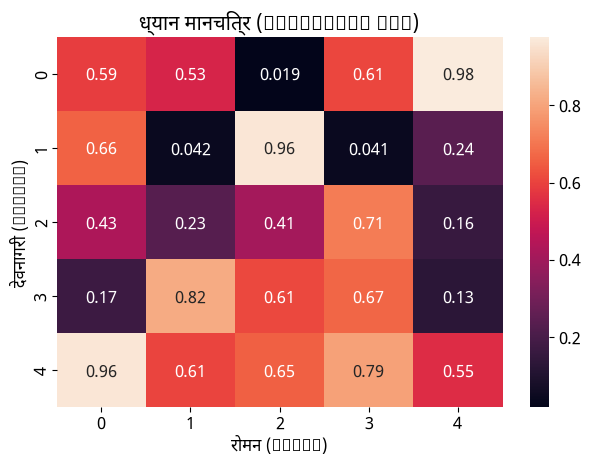

In [118]:
# Install font support (only once per Kaggle session)
!apt-get -qq install fonts-noto fonts-noto-cjk
!fc-cache -fv

# Set global font
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Noto Sans Devanagari'



Fonts set: ['Noto Sans Devanagari', 'DejaVu Sans']


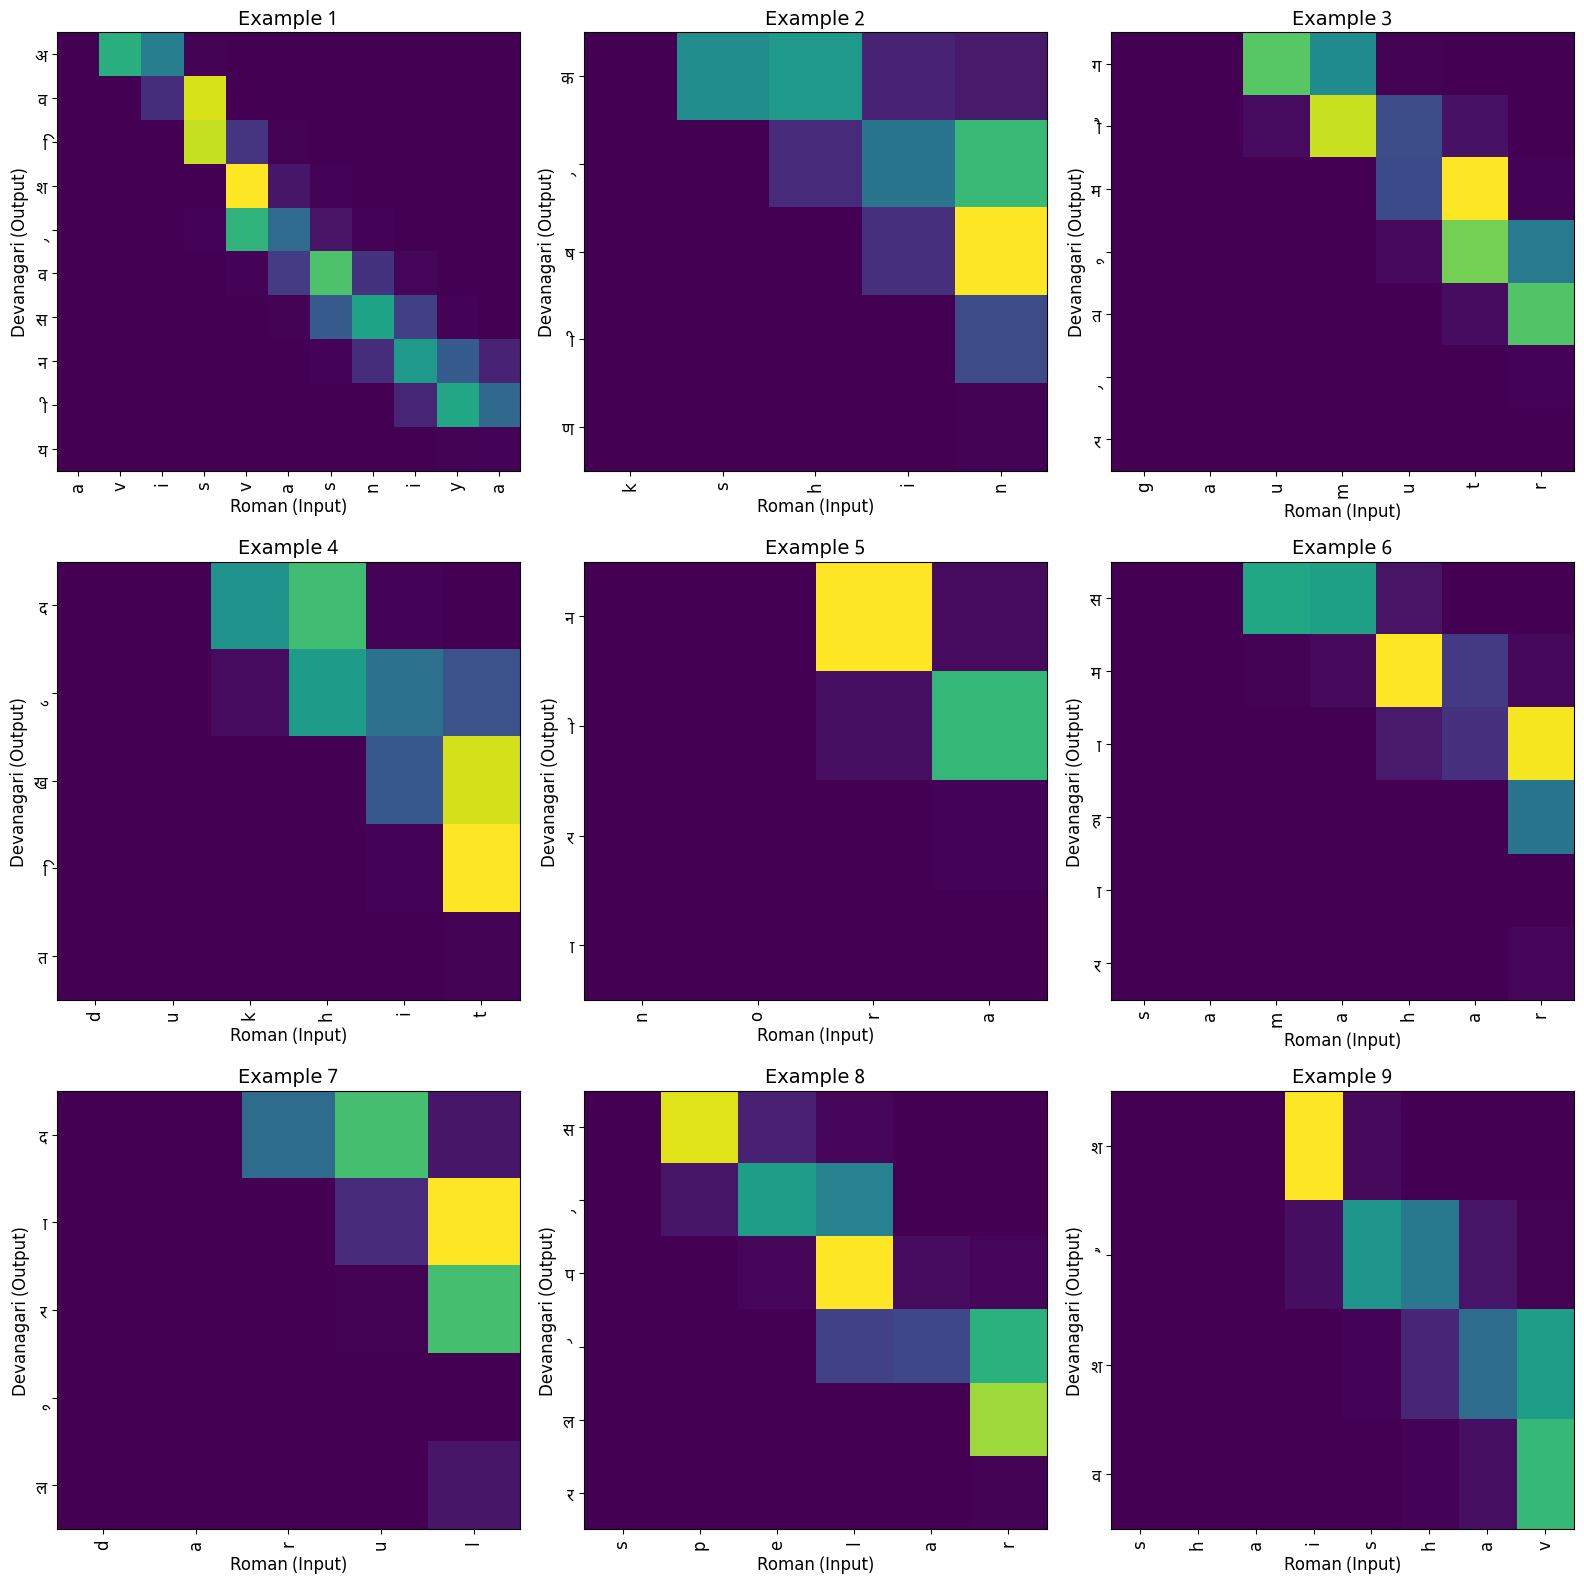

In [129]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import random

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 1. Get Devanagari and Latin-compatible fonts
devanagari_path = "/usr/share/fonts/truetype/noto/NotoSansDevanagari-Regular.ttf"
latin_font_path = fm.findfont("DejaVu Sans")  # This returns the correct existing path

# 2. Load them using FontProperties
devanagari = fm.FontProperties(fname=devanagari_path)
latin = fm.FontProperties(fname=latin_font_path)

# 3. Apply fallback font family list
mpl.rcParams['font.family'] = [devanagari.get_name(), latin.get_name()]

# ✅ Confirm loaded fonts
print("Fonts set:", mpl.rcParams['font.family'])

# Ensure model is in eval mode and loaded
model.load_state_dict(torch.load("best_attention_model2.pt"))
model.eval()

# Reverse vocab maps
INV_SRC = {v: k for k, v in SRC_VOCAB.items()}
INV_TGT = {v: k for k, v in TGT_VOCAB.items()}

# Function to get attention weights
def get_attentions(model, src_tensor, max_len=32):
    model.eval()
    with torch.no_grad():
        enc_out, enc_h = model.encoder(src_tensor)
        dec_h = model._init_decoder_hidden(enc_h)
        inp = torch.full((1,), TGT_VOCAB['<sos>'], dtype=torch.long, device=DEVICE)
        attentions = []
        for _ in range(max_len):
            logits, dec_h, attn = model.decoder(inp, dec_h, enc_out)
            if attn is not None:
                attentions.append(attn.squeeze(0))  # keep as torch tensor
            inp = logits.argmax(1)
        return torch.stack(attentions)  # shape: [tgt_len, src_len]

# Sample 9 random examples from test data
sample_loader = DataLoader(test_ds, batch_size=1, shuffle=True, collate_fn=collate_fn)
samples = []
for src, tgt in sample_loader:
    samples.append((src, tgt))
    if len(samples) == 9:
        break

# Plot 3x3 attention heatmaps
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
plt.rcParams.update({'font.size': 12})
for i, (src, tgt) in enumerate(samples):
    src = src.to(DEVICE)
    attn_weights = get_attentions(model, src)[1:]  # skip <sos> attention
    src_tokens = [INV_SRC[idx.item()] for idx in src[0] if INV_SRC[idx.item()] not in ['<pad>', '<eos>']]
    tgt_tokens = [INV_TGT[idx.item()] for idx in tgt[0] if INV_TGT[idx.item()] not in ['<pad>', '<sos>', '<eos>']]

    # Clip attention to actual token lengths
    attn_matrix = attn_weights[:len(tgt_tokens), :len(src_tokens)].cpu().numpy()

    ax = axes[i // 3][i % 3]
    im = ax.imshow(attn_matrix, cmap='viridis', aspect='auto')
    ax.set_xticks(range(len(src_tokens)))
    ax.set_yticks(range(len(tgt_tokens)))
    ax.set_xticklabels(src_tokens, rotation=90, fontsize=12)
    ax.set_yticklabels(tgt_tokens, fontsize=12)
    ax.set_xlabel("Roman (Input)", fontsize=12)
    ax.set_ylabel("Devanagari (Output)", fontsize=12)
    ax.set_title(f"Example {i+1}", fontsize=14)
fig.tight_layout()
fig.savefig("/kaggle/working/predictions_attention/heatmaps/attention_grid_3x3.png", dpi=300)

plt.show()


In [128]:
import wandb

# Save the plot locally first
plot_path = "attention_grid_3x3.png"
plt.savefig(plot_path, dpi=300)

# Log to wandb
wandb.init(project="assignment3_attention_heatmap")  # replace with your project if needed
wandb.log({"Attention Heatmaps (3x3 Grid)": wandb.Image(plot_path)})

print("✅ Uploaded 3x3 attention heatmaps to wandb.")


✅ Uploaded 3x3 attention heatmaps to wandb.


<Figure size 640x480 with 0 Axes>

In [60]:
import wandb
import shutil

# 1) Restore the file that you saved in that run
local_file = wandb.restore(
    "best_attention_model.pt",
    run_path="ed24s401-indian-institute-of-technology-madras/assignment3_sweep_attention/nng2zsjt"
)

print("Downloaded to:", local_file.name)
# e.g. → "./wandb/run-20250520_015820-lafocek1/files/best_attention_model.pt"

# 2) Copy/rename it to whatever you want in your working dir
shutil.copy(local_file.name, "best_attention_lstmm.pt")
print("Saved best_attention_lstmm.pt")



Downloaded to: /kaggle/working/best_attention_model.pt
Saved best_attention_lstmm.pt
